<a href="https://colab.research.google.com/github/s11khushboo/robot-adviser/blob/main/Final__M2_Product_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4: ROBO REVIEWS**_MODEL 2
Group 5:


**M2_PRODUCT CLUSTERING MODEL**

**PROJECT GOAL:**

**Development of a product review website powered by NLP models**

The models aggregate customer feedback from different sources

**Main tasks:**
1. Classify customer reviews into positive, negative, or neutral categories to help the company improve its products and services.

**2. Cluster product categories into just 4-6 of them**

Use Generative AI to summarize reviews into an article which recommends the top products for each category  

3. Find and reuse existing LLMs, don’t use classical techniques


# Project Structure
product_review_analytics/

├── app.py                 # Main Flask/FastAPI application

├── models/

│   ├── sentiment_model.py

│   ├── **clustering_model.py**

│   └── llm_summarizer.py

├── static/

│   └── css/

├── templates/

│   └── index.html

└── data/
    └── sample_reviews.csv

**Let's outline the code structure:**

Data Loading and Preprocessing

Sentiment Classification

**Product Clustering**

Top Product Selection per Cluster

LLM Summary and Article Generation

# **PRODUCT CLUSTERING MODEL**

The dataset categories are too sparse. Create a model to group all reviews into 4-6 “meta” categories.

Here’s a suggestion, but you can choose any categories after analyzing your dataset in depth:
Ebook readers
Batteries
Accessories (keyboards, laptop stand, …)
Non-electronics (nespresso pods, pet carrier…)....


Product Clustering and Top Product Selection Pipeline

In [ ]:
# ======================
# STEP 1: IMPORTS & SETUP
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import scipy.sparse as sp
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data Loading & Preprocessing**

**DATA:**

**Original dataset:**
https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data

Alternative:
Larger dataset:
https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews



[link text](https://)

**STEP 2: DATA LOADING & CONCATENATION**

In [3]:
# ======================
# STEP 2: DATA LOADING
# ======================


import pandas as pd
import glob
import os

# List all CSV files in the current directory
csv_files = glob.glob("*.csv")
print(f"📁 Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"   • {file}")

# Load CSV into a separate DataFrame
df = pd.read_csv(csv_files[0])


print(f"   Loaded DataFrame:")
print(f"   df Shape: {df.shape}")
print(f"   Total rows: {len(df):,}")
print(f"   Columns: {list(df.columns)}")

📁 Found 1 CSV files:
   • clean_reviews (1).csv
   Loaded DataFrame:
   df Shape: (60321, 14)
   Total rows: 60,321
   Columns: ['id', 'name', 'brand', 'categories', 'primaryCategories', 'reviews.doRecommend', 'reviews.numHelpful', 'star_rating', 'review_text', 'review_title', 'sentiment', 'text_sentiment', 'rating_sentiment', 'match']


In [4]:
import pandas as pd
import numpy as np

# Display ALL columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📋 ALL COLUMNS IN THE DATASET:")
print("=" * 60)


# Print all columns with their data types
print("COLUMNS AND DATA TYPES:")
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    missing = df[col].isnull().sum()
    print(f"{i:2d}. {col:30} | {str(dtype):10} | Missing: {missing:4}")

print(f"\n📊 Total columns: {len(df.columns)}")

📋 ALL COLUMNS IN THE DATASET:
COLUMNS AND DATA TYPES:
 1. id                             | object     | Missing:    0
 2. name                           | object     | Missing: 6144
 3. brand                          | object     | Missing:    0
 4. categories                     | object     | Missing:    0
 5. primaryCategories              | object     | Missing: 31190
 6. reviews.doRecommend            | object     | Missing: 10467
 7. reviews.numHelpful             | float64    | Missing: 10402
 8. star_rating                    | float64    | Missing:    0
 9. review_text                    | object     | Missing:    0
10. review_title                   | object     | Missing:   19
11. sentiment                      | object     | Missing:    0
12. text_sentiment                 | object     | Missing:    0
13. rating_sentiment               | object     | Missing:    0
14. match                          | bool       | Missing:    0

📊 Total columns: 14


In [5]:
# 11. sentiment                      | object     | Missing:    0
# 12. text_sentiment                 | object     | Missing:    0
# 13. rating_sentiment               | object     | Missing:
# 14. match                          | bool       | Missing:    0

## columns need to be taken into consideration and dropped
## no missing values in relevant columns for model

df1 = df.drop(['sentiment', 'text_sentiment', 'rating_sentiment', 'match'], axis=1)

# **Product Clustering and Top Product Selection Pipeline**

We are going to perform the following steps:

- Load the dataset and explore the product categories to understand the current distribution.

- Preprocess the text data (product categories and possibly review text) to prepare for clustering.

- Use NLP techniques (like TF-IDF or word embeddings) to vectorize the product categories (and maybe review text if needed).

- Apply a clustering algorithm (like K-means) to group the products into 4-6 meta categories.

- Evaluate the clusters and assign meaningful labels to each cluster.

- Select top products per cluster based on some criteria (e.g., average rating, number of reviews)

However, note: the dataset categories are too sparse. So we might need to use the product category names and possibly the review text to create the clusters.

Data set columns at least:

product_id; product_category (the original category); review_text (optional, but if we want to use it for clustering); rating (optional, for top product selection)

**Steps in code:**

1. Libraries and Environment

2. Load the data

3. Preprocessing:

For product category: we might have a hierarchical structure. We can use the leaf category or the entire hierarchy.

If using review text: we will clean and preprocess the text (lowercasing, removing punctuation, stopwords, etc.)

4. Feature Extraction:

We can use TF-IDF on the product category names (and if needed, on the review text) to create a feature matrix.

Alternatively, we can use pre-trained word embeddings to get a representation for each product (by averaging the embeddings of the words in the category and maybe the review text).

5. Clustering:

We'll use K-means with n_clusters between 4 and 6. We can use the elbow method to choose the best k.

6. Cluster Analysis:

We'll look at the top terms in each cluster (if using TF-IDF) or the closest words to the cluster centroid (if using word embeddings) to assign a meaningful label.

7. Top Product Selection:

For each cluster, we can select the top products based on the average rating and the number of reviews (to ensure reliability).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import re
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [8]:
# ======================
# STEP 2: DATA EXPLORATION & UNDERSTANDING
# ======================
print("\n" + "="*50)
print("STEP 2: DATA EXPLORATION")
print("="*50)

def explore_data(df):
    """Comprehensive data exploration"""
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"📝 Total Records: {len(df):,}")

    # Basic info about key columns
    print("\n🔍 KEY COLUMNS ANALYSIS:")
    key_columns = ['asins', 'categories', 'reviews.rating', 'reviews.text', 'brand', 'name']
    for col in key_columns:
        if col in df.columns:
            non_null = df[col].notna().sum()
            unique = df[col].nunique()
            print(f"   {col}: {non_null:,} non-null, {unique:,} unique")

    # Analyze categories structure
    print("\n🏷️  CATEGORIES ANALYSIS:")
    # Sample some categories to understand the structure
    sample_categories = df['categories'].dropna().head(10)
    for i, cat in enumerate(sample_categories):
        print(f"   Sample {i+1}: {cat}")

    return df

# Run exploration
df = explore_data(df)


STEP 2: DATA EXPLORATION
📊 Dataset Shape: (60321, 14)
📝 Total Records: 60,321

🔍 KEY COLUMNS ANALYSIS:
   categories: 60,321 non-null, 106 unique
   brand: 60,321 non-null, 7 unique
   name: 54,177 non-null, 123 unique

🏷️  CATEGORIES ANALYSIS:
   Sample 1: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 2: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 3: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 4: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 5: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 6: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 7: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 8: Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
   Sample 

STEP 3 — Data Cleaning & Text Preprocessing
Extract useful columns & preprocess text

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import re
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*50)
print("STEP 3: DATA PREPROCESSING")
print("="*50)

def preprocess_data(df):
    """
    Preprocess the data for clustering:
    - Handle hierarchical categories
    - Clean text data
    - Create product-level dataset
    """

    def extract_categories(category_data):
        """Extract and process hierarchical categories"""
        if pd.isna(category_data):
            return []

        try:
            # Handle string representation of lists
            if isinstance(category_data, str) and '[' in category_data:
                categories = ast.literal_eval(category_data)
            elif isinstance(category_data, list):
                categories = category_data
            else:
                categories = [str(category_data)]

            return categories if isinstance(categories, list) else [str(categories)]
        except:
            return [str(category_data)]

    def clean_text(text):
        """Clean and standardize text data"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def combine_categories(categories_list):
        """Combine all categories into a single processed string"""
        if not categories_list:
            return "unknown"

        # Clean each category
        cleaned_categories = [clean_text(cat) for cat in categories_list]

        # Remove duplicates and empty categories
        unique_categories = [cat for cat in set(cleaned_categories) if cat and cat != "unknown"]

        # Combine into single string for feature extraction
        return " ".join(unique_categories)

    print("1. \U0001f527 Processing hierarchical categories...")
    df['all_categories'] = df['categories'].apply(extract_categories)

    print("2. \U0001f4e6 Creating product-level dataset...")
    # Group by product (ASIN) to create product-level data
    product_data = df.groupby('id').agg({
        'all_categories': 'first',
        'name': 'first',
        'brand': 'first',
        'star_rating': ['mean', 'count', 'std'],
        'review_text': 'count'
    }).reset_index()

    # Flatten column names
    product_data.columns = ['id', 'all_categories', 'name', 'brand',
                           'avg_rating', 'rating_count', 'rating_std', 'review_count']

    # Filter out products with no categories or reviews
    initial_count = len(product_data)
    product_data = product_data[product_data['all_categories'].apply(len) > 0]
    product_data = product_data[product_data['review_count'] > 0]

    print(f"   - Removed {initial_count - len(product_data)} products without categories/reviews")
    print(f"   - Final product count: {len(product_data):,}")

    print("3. \U0001f9f9 Cleaning and combining categories...")
    product_data['processed_categories'] = product_data['all_categories'].apply(combine_categories)

    # Analyze the processed data
    category_lengths = product_data['processed_categories'].str.len()
    print(f"   - Average category text length: {category_lengths.mean():.1f} characters")
    print(f"   - Unique products processed: {len(product_data):,}")

    return product_data

# Apply preprocessing
product_data = preprocess_data(df)



STEP 3: DATA PREPROCESSING
1. 🔧 Processing hierarchical categories...
2. 📦 Creating product-level dataset...
   - Removed 0 products without categories/reviews
   - Final product count: 87
3. 🧹 Cleaning and combining categories...
   - Average category text length: 196.9 characters
   - Unique products processed: 87


**STEP 4 — TF-IDF Vectorization**

We vectorize text → numerical features for clustering

In [12]:
# ======================
# STEP 4: FEATURE EXTRACTION
# ======================
print("\n" + "="*50)
print("STEP 4: FEATURE EXTRACTION")
print("="*50)

def extract_features(product_data):
    """
    Extract features from text data using TF-IDF
    """
    print("1. 🎯 Applying TF-IDF vectorization...")

    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        max_features=100,        # Limit to top 100 features
        stop_words='english',    # Remove common English words
        ngram_range=(1, 2),      # Include single words and 2-word phrases
        min_df=2,               # Ignore terms that appear in only 1 product
        max_df=0.8              # Ignore terms that appear in >80% of products
    )

    # Fit and transform the processed categories
    tfidf_matrix = vectorizer.fit_transform(product_data['processed_categories'])
    features = tfidf_matrix.toarray()

    print(f"2. 📊 Feature matrix created: {features.shape}")
    print(f"   - Samples: {features.shape[0]}")
    print(f"   - Features: {features.shape[1]}")

    # Show top features
    feature_names = vectorizer.get_feature_names_out()
    print(f"   - Top 10 feature terms: {feature_names[:10]}")

    # Feature importance analysis
    feature_importance = np.array(features.mean(axis=0)).flatten()
    top_features_idx = feature_importance.argsort()[-10:][::-1]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_features_idx]

    print(f"   - Most important features:")
    for term, score in top_features:
        print(f"     '{term}': {score:.4f}")

    return features, vectorizer

# Extract features
features, vectorizer = extract_features(product_data)


STEP 4: FEATURE EXTRACTION
1. 🎯 Applying TF-IDF vectorization...
2. 📊 Feature matrix created: (87, 100)
   - Samples: 87
   - Features: 100
   - Top 10 feature terms: ['accessories' 'accessories electronics' 'accessories kindle' 'adapters'
 'adapters cables' 'amazon' 'amazon device' 'amazon devices' 'amazon echo'
 'amazon home']
   - Most important features:
     'tablets': 0.2459
     'accessories': 0.1227
     'readers': 0.1000
     'tablets tablets': 0.0938
     'electronics': 0.0935
     'amazon': 0.0912
     'computers': 0.0877
     'home': 0.0834
     'computers tablets': 0.0727
     'kindle': 0.0658


 STEP 5 — K-Means Clustering
🔎 Find best cluster count (Elbow method)


STEP 5: CLUSTERING
1. 🔍 Finding optimal number of clusters...
   k=2: Inertia=55.61, Silhouette=0.199
   k=3: Inertia=48.70, Silhouette=0.240
   k=4: Inertia=42.90, Silhouette=0.235
   k=5: Inertia=38.58, Silhouette=0.269
   k=6: Inertia=34.73, Silhouette=0.283
   k=7: Inertia=31.30, Silhouette=0.306
   k=8: Inertia=29.52, Silhouette=0.305
   k=9: Inertia=27.26, Silhouette=0.337
   k=10: Inertia=25.91, Silhouette=0.332
   k=11: Inertia=24.29, Silhouette=0.352
   k=12: Inertia=23.37, Silhouette=0.280
2. 🎯 Selected optimal k: 6 (within range 4-6)


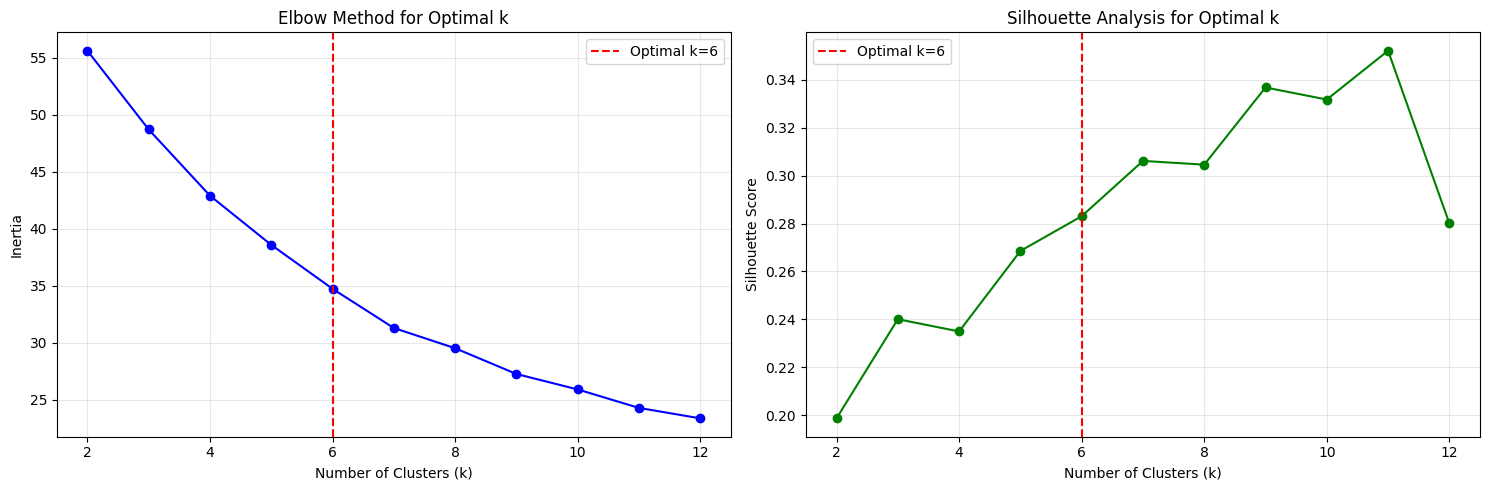

3. 🌀 Performing K-means clustering with 6 clusters...
   - Silhouette Score: 0.283 (higher is better)
   - Calinski-Harabasz Score: 16.349 (higher is better)
   - Cluster distribution:
     Cluster 0: 12 products (13.8%)
     Cluster 1: 12 products (13.8%)
     Cluster 2: 17 products (19.5%)
     Cluster 3: 24 products (27.6%)
     Cluster 4: 9 products (10.3%)
     Cluster 5: 13 products (14.9%)


In [13]:
# ======================
# STEP 5: CLUSTERING WITH OPTIMAL K SELECTION
# ======================
print("\n" + "="*50)
print("STEP 5: CLUSTERING")
print("="*50)

def find_optimal_clusters(features, max_k=12):
    """
    Use elbow method and silhouette analysis to find optimal number of clusters
    """
    print("1. 🔍 Finding optimal number of clusters...")

    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)

        inertias.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print(f"   k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.3f}")

    # Find optimal k in range 4-6 based on silhouette scores
    k_candidates = list(range(4, 7))
    best_k = max(k_candidates, key=lambda k: silhouette_scores[k-2])  # -2 because k_range starts at 2

    print(f"2. 🎯 Selected optimal k: {best_k} (within range 4-6)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow curve
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'go-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis for Optimal k')
    ax2.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return best_k, inertias, silhouette_scores

def perform_clustering(features, n_clusters):
    """
    Perform K-means clustering with specified number of clusters
    """
    print(f"3. 🌀 Performing K-means clustering with {n_clusters} clusters...")

    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=15,
        max_iter=300
    )

    cluster_labels = kmeans.fit_predict(features)

    # Calculate clustering quality metrics
    silhouette_avg = silhouette_score(features, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(features, cluster_labels)

    print(f"   - Silhouette Score: {silhouette_avg:.3f} (higher is better)")
    print(f"   - Calinski-Harabasz Score: {calinski_harabasz:.3f} (higher is better)")

    # Add cluster labels to product data
    product_data_clustered = product_data.copy()
    product_data_clustered['cluster'] = cluster_labels

    # Analyze cluster distribution
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print(f"   - Cluster distribution:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(cluster_labels)) * 100
        print(f"     Cluster {cluster_id}: {count} products ({percentage:.1f}%)")

    return cluster_labels, kmeans, product_data_clustered

# Find optimal k and perform clustering
optimal_k, inertias, silhouette_scores = find_optimal_clusters(features)
cluster_labels, kmeans_model, product_data_clustered = perform_clustering(features, optimal_k)

**Choose 4–6 clusters based on elbow drop.Let's assume 6 clusters for now:**

STEP 6 — Interpret Clusters (Top Words)


STEP 6: CLUSTER ANALYSIS & LABELING
1. 🔬 Analyzing cluster characteristics...

   🔸 Cluster 0 - E-Readers_Kindle:
      - Products: 12
      - Avg Rating: 4.73 ⭐
      - Total Reviews: 5,551
      - Top 5 Terms: ['readers', 'tablets', 'kindle readers', 'readers accessories', 'kindle']
      - Common Themes: ['kindle', 'tablet', 'fire']
      - Sample Products:
        1. All-New Kindle Oasis E-reader - 7 High-Resolution Display (3...
           Brand: Amazon, Rating: 4.75⭐
        2. All-New Kindle Oasis E-reader - 7 High-Resolution Display (3...
           Brand: Amazon, Rating: 4.65⭐
        3. Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrom...
           Brand: Amazon, Rating: 4.82271186440678⭐

   🔸 Cluster 1 - Smart_Home_Devices:
      - Products: 12
      - Avg Rating: 4.59 ⭐
      - Total Reviews: 8,621
      - Top 5 Terms: ['home', 'smart', 'speakers', 'amazon', 'smart home']
      - Common Themes: ['echo']
      - Sample Products:
        1. Echo (White),,,
Echo 

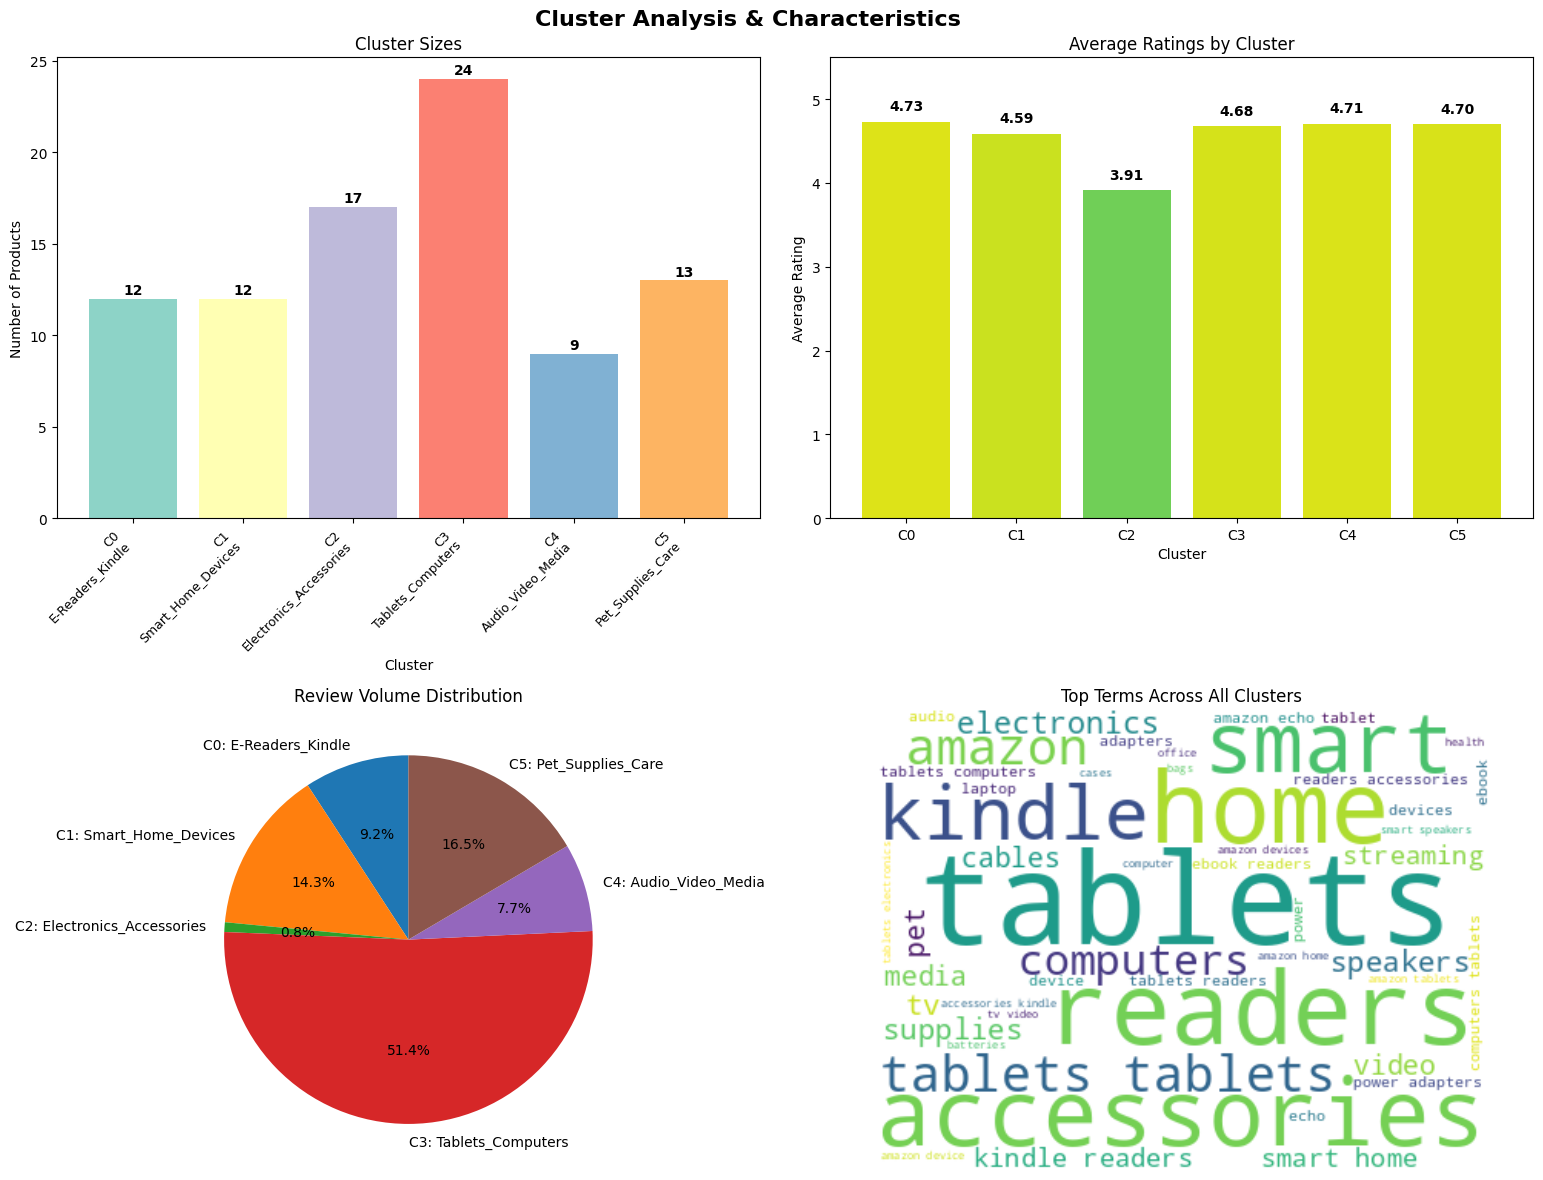


CLUSTER VALIDATION
Validating cluster distinctiveness...
✅ All clusters have unique labels
📊 Cluster size statistics:
   - Mean: 14.5 products per cluster
   - Std Dev: 4.9
   - Size range: 9 to 24 products
✅ All clusters have reasonable sizes
⭐ Rating range across clusters: 3.91 to 4.73 (range: 0.82)

🎯 CLUSTER LABELING SUMMARY:
Cluster 0: E-Readers_Kindle
  - 12 products, 4.73 avg rating
  - Key terms: ['readers', 'tablets', 'kindle readers']

Cluster 1: Smart_Home_Devices
  - 12 products, 4.59 avg rating
  - Key terms: ['home', 'smart', 'speakers']

Cluster 2: Electronics_Accessories
  - 17 products, 3.91 avg rating
  - Key terms: ['accessories', 'cables', 'kindle']

Cluster 3: Tablets_Computers
  - 24 products, 4.68 avg rating
  - Key terms: ['tablets', 'tablets tablets', 'tablets computers']

Cluster 4: Audio_Video_Media
  - 9 products, 4.71 avg rating
  - Key terms: ['tv', 'video', 'media']

Cluster 5: Pet_Supplies_Care
  - 13 products, 4.70 avg rating
  - Key terms: ['supplies'

In [14]:
# ======================
# STEP 6: CLUSTER ANALYSIS & LABELING (IMPROVED)
# ======================
print("\n" + "="*50)
print("STEP 6: CLUSTER ANALYSIS & LABELING")
print("="*50)

def analyze_clusters(product_data, cluster_labels, vectorizer, features):
    """
    Analyze clusters and assign meaningful labels with improved logic
    """
    print("1. 🔬 Analyzing cluster characteristics...")

    def get_cluster_terms(cluster_features, vectorizer, top_n=10):
        """Get top terms for a cluster based on TF-IDF scores"""
        cluster_avg_features = cluster_features.mean(axis=0)
        feature_names = vectorizer.get_feature_names_out()
        top_indices = cluster_avg_features.argsort()[-top_n:][::-1]
        return [(feature_names[i], cluster_avg_features[i]) for i in top_indices]

    def assign_cluster_label(top_terms, sample_products, cluster_id):
        """Assign meaningful label based on top terms, sample products, and cluster analysis"""
        terms_dict = {term: score for term, score in top_terms}

        # Enhanced category mappings with more specific categories
        category_keywords = {
            'Tablets_Computers': ['tablet', 'tablets', 'computer', 'laptop', 'notebook', 'macbook', 'fire', 'kindle fire'],
            'E-Readers_Kindle': ['kindle', 'ebook', 'e-reader', 'ereader', 'voyage', 'paperwhite', 'readers'],
            'Electronics_Accessories': ['accessory', 'accessories', 'cables', 'adapters', 'power', 'charger', 'battery'],
            'Audio_Video_Media': ['audio', 'video', 'media', 'tv', 'streaming', 'speaker', 'headphone'],
            'Smart_Home_Devices': ['home', 'smart', 'echo', 'dot', 'alexa', 'smart home', 'assistant'],
            'Pet_Supplies_Care': ['pet', 'dog', 'cat', 'carrier', 'kennel', 'crate', 'supplies', 'health'],
            'Mobile_Tablets': ['mobile', 'phone', 'tablet', 'android', 'ios', 'cellular'],
            'Gaming_Entertainment': ['gaming', 'game', 'console', 'controller', 'entertainment'],
            'Camera_Photography': ['camera', 'photo', 'photography', 'lens', 'digital']
        }

        # Calculate scores for each category
        scores = {}
        for category, keywords in category_keywords.items():
            score = 0
            for keyword in keywords:
                # Check if keyword appears in any of the top terms
                for term, term_score in top_terms:
                    if keyword in term:
                        score += term_score * 2  # Higher weight for exact matches
                # Also check if keyword is in sample product names
                for product in sample_products:
                    product_name = str(product.get('name', '')).lower()
                    if keyword in product_name:
                        score += 1  # Additional weight for product name matches
            scores[category] = score

        # Get top 2 categories
        top_categories = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:2]

        # If no strong matches, analyze the cluster more deeply
        if all(score == 0 for score in scores.values()):
            return f"General_Products_Cluster{cluster_id}"

        # If we have a clear winner (score at least 2x the second), use that category
        if top_categories[0][1] >= top_categories[1][1] * 2:
            return top_categories[0][0]
        else:
            # Combine the top two categories
            combined_label = f"{top_categories[0][0]}_{top_categories[1][0]}"
            # Simplify the label if it's too long
            if len(combined_label) > 25:
                return top_categories[0][0]
            return combined_label

    def analyze_sample_products(sample_products):
        """Analyze sample products to extract common themes"""
        product_names = [str(p.get('name', '')).lower() for p in sample_products]
        brands = [str(p.get('brand', '')).lower() for p in sample_products if pd.notna(p.get('brand'))]

        common_keywords = {
            'tablet': 0, 'kindle': 0, 'echo': 0, 'fire': 0, 'accessory': 0,
            'pet': 0, 'dog': 0, 'cat': 0, 'home': 0, 'smart': 0,
            'camera': 0, 'video': 0, 'audio': 0, 'gaming': 0, 'computer': 0
        }

        for name in product_names:
            for keyword in common_keywords:
                if keyword in name:
                    common_keywords[keyword] += 1

        return common_keywords

    cluster_analysis = {}
    unique_clusters = np.unique(cluster_labels)

    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_products = product_data[cluster_mask]
        cluster_features = features[cluster_mask]

        # Get top terms
        top_terms = get_cluster_terms(cluster_features, vectorizer)

        # Get sample products
        sample_products = cluster_products[['name', 'brand', 'avg_rating']].head(5).to_dict('records')  # Increased to 5 for better analysis

        # Analyze sample products for additional context
        product_analysis = analyze_sample_products(sample_products)

        # Assign label with cluster_id for context
        cluster_label = assign_cluster_label(top_terms, sample_products, cluster_id)

        # Store analysis
        cluster_analysis[cluster_id] = {
            'label': cluster_label,
            'size': len(cluster_products),
            'top_terms': top_terms,
            'sample_products': sample_products,
            'avg_rating': cluster_products['avg_rating'].mean(),
            'total_reviews': cluster_products['review_count'].sum(),
            'product_analysis': product_analysis
        }

        print(f"\n   🔸 Cluster {cluster_id} - {cluster_label}:")
        print(f"      - Products: {len(cluster_products)}")
        print(f"      - Avg Rating: {cluster_products['avg_rating'].mean():.2f} ⭐")
        print(f"      - Total Reviews: {cluster_products['review_count'].sum():,}")
        print(f"      - Top 5 Terms: {[term for term, score in top_terms[:5]]}")

        # Show product analysis insights
        top_keywords = [k for k, v in sorted(product_analysis.items(), key=lambda x: x[1], reverse=True) if v > 0][:3]
        if top_keywords:
            print(f"      - Common Themes: {top_keywords}")

        print(f"      - Sample Products:")
        for i, product in enumerate(sample_products[:3]):  # Show first 3 samples
            product_name = product.get('name', 'Unknown Product Name')
            product_brand = product.get('brand', 'Unknown Brand')

            # Clean and format the display
            name_to_display = str(product_name) if pd.notna(product_name) else "Unknown Product Name"
            brand_to_display = str(product_brand) if pd.notna(product_brand) else "Unknown Brand"

            # Truncate for display
            display_name = name_to_display[:60] + "..." if len(name_to_display) > 60 else name_to_display

            print(f"        {i+1}. {display_name}")
            print(f"           Brand: {brand_to_display}, Rating: {product.get('avg_rating', 'N/A')}⭐")

    # Add labels to product data
    label_mapping = {cluster_id: analysis['label'] for cluster_id, analysis in cluster_analysis.items()}
    product_data['cluster_label'] = product_data['cluster'].map(label_mapping)

    return cluster_analysis

# Analyze clusters with improved logic
cluster_analysis = analyze_clusters(product_data_clustered, cluster_labels, vectorizer, features)

# ======================
# VISUALIZE CLUSTER CHARACTERISTICS
# ======================
print("\n" + "="*50)
print("CLUSTER CHARACTERISTICS VISUALIZATION")
print("="*50)

def visualize_cluster_characteristics(cluster_analysis):
    """Create visualization to show cluster differences"""
    import matplotlib.pyplot as plt

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cluster Analysis & Characteristics', fontsize=16, fontweight='bold')

    # Plot 1: Cluster Sizes
    clusters = list(cluster_analysis.keys())
    sizes = [analysis['size'] for analysis in cluster_analysis.values()]
    labels = [analysis['label'] for analysis in cluster_analysis.values()]

    bars = ax1.bar(range(len(sizes)), sizes, color=plt.cm.Set3(range(len(sizes))))
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Number of Products')
    ax1.set_title('Cluster Sizes')
    ax1.set_xticks(range(len(sizes)))
    ax1.set_xticklabels([f'C{i}\n{label}' for i, label in enumerate(labels)], rotation=45, ha='right', fontsize=9)

    for bar, size in zip(bars, sizes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{size}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Average Ratings
    ratings = [analysis['avg_rating'] for analysis in cluster_analysis.values()]
    bars = ax2.bar(range(len(ratings)), ratings, color=plt.cm.viridis(np.array(ratings)/5))
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Average Rating')
    ax2.set_title('Average Ratings by Cluster')
    ax2.set_xticks(range(len(ratings)))
    ax2.set_xticklabels([f'C{i}' for i in clusters], rotation=0)
    ax2.set_ylim(0, 5.5)

    for bar, rating in zip(bars, ratings):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{rating:.2f}', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Review Volume
    reviews = [analysis['total_reviews'] for analysis in cluster_analysis.values()]
    ax3.pie(reviews, labels=[f'C{i}: {label}' for i, label in enumerate(labels)],
            autopct='%1.1f%%', startangle=90)
    ax3.set_title('Review Volume Distribution')

    # Plot 4: Top Terms Word Cloud (across all clusters)
    from wordcloud import WordCloud
    all_terms = {}
    for analysis in cluster_analysis.values():
        for term, score in analysis['top_terms']:
            all_terms[term] = all_terms.get(term, 0) + score

    if all_terms:
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             max_words=50).generate_from_frequencies(all_terms)
        ax4.imshow(wordcloud, interpolation='bilinear')
        ax4.set_title('Top Terms Across All Clusters')
        ax4.axis('off')

    plt.tight_layout()
    plt.show()

# Create visualization
visualize_cluster_characteristics(cluster_analysis)

# ======================
# CLUSTER VALIDATION
# ======================
print("\n" + "="*50)
print("CLUSTER VALIDATION")
print("="*50)

def validate_clusters(cluster_analysis):
    """Validate cluster quality and distinctiveness"""
    print("Validating cluster distinctiveness...")

    # Check for duplicate labels
    labels = [analysis['label'] for analysis in cluster_analysis.values()]
    unique_labels = set(labels)

    if len(unique_labels) < len(labels):
        duplicate_labels = [label for label in labels if labels.count(label) > 1]
        print(f"⚠️  Warning: Duplicate labels found: {set(duplicate_labels)}")
    else:
        print("✅ All clusters have unique labels")

    # Check cluster size balance
    sizes = [analysis['size'] for analysis in cluster_analysis.values()]
    size_std = np.std(sizes)
    size_mean = np.mean(sizes)

    print(f"📊 Cluster size statistics:")
    print(f"   - Mean: {size_mean:.1f} products per cluster")
    print(f"   - Std Dev: {size_std:.1f}")
    print(f"   - Size range: {min(sizes)} to {max(sizes)} products")

    # Check if any cluster is too small
    small_clusters = [i for i, analysis in cluster_analysis.items() if analysis['size'] < 5]
    if small_clusters:
        print(f"⚠️  Warning: Small clusters (less than 5 products): {small_clusters}")
    else:
        print("✅ All clusters have reasonable sizes")

    # Analyze rating distribution
    ratings = [analysis['avg_rating'] for analysis in cluster_analysis.values()]
    rating_range = max(ratings) - min(ratings)
    print(f"⭐ Rating range across clusters: {min(ratings):.2f} to {max(ratings):.2f} (range: {rating_range:.2f})")

    return {
        'unique_labels': len(unique_labels) == len(labels),
        'balanced_sizes': size_std < size_mean * 0.8,  # Std dev less than 80% of mean
        'no_small_clusters': len(small_clusters) == 0,
        'rating_variation': rating_range > 0.3  # Reasonable variation in ratings
    }

# Validate clusters
validation_results = validate_clusters(cluster_analysis)

print(f"\n🎯 CLUSTER LABELING SUMMARY:")
print("=" * 40)
for cluster_id, analysis in cluster_analysis.items():
    print(f"Cluster {cluster_id}: {analysis['label']}")
    print(f"  - {analysis['size']} products, {analysis['avg_rating']:.2f} avg rating")
    print(f"  - Key terms: {[term for term, score in analysis['top_terms'][:3]]}")
    print()



CLUSTER VISUALIZATION - 2D & 3D PROJECTIONS
1. 🎨 Creating 2D and 3D cluster visualizations...
   - Reducing dimensions using PCA and t-SNE...
   - Creating 2D visualizations...


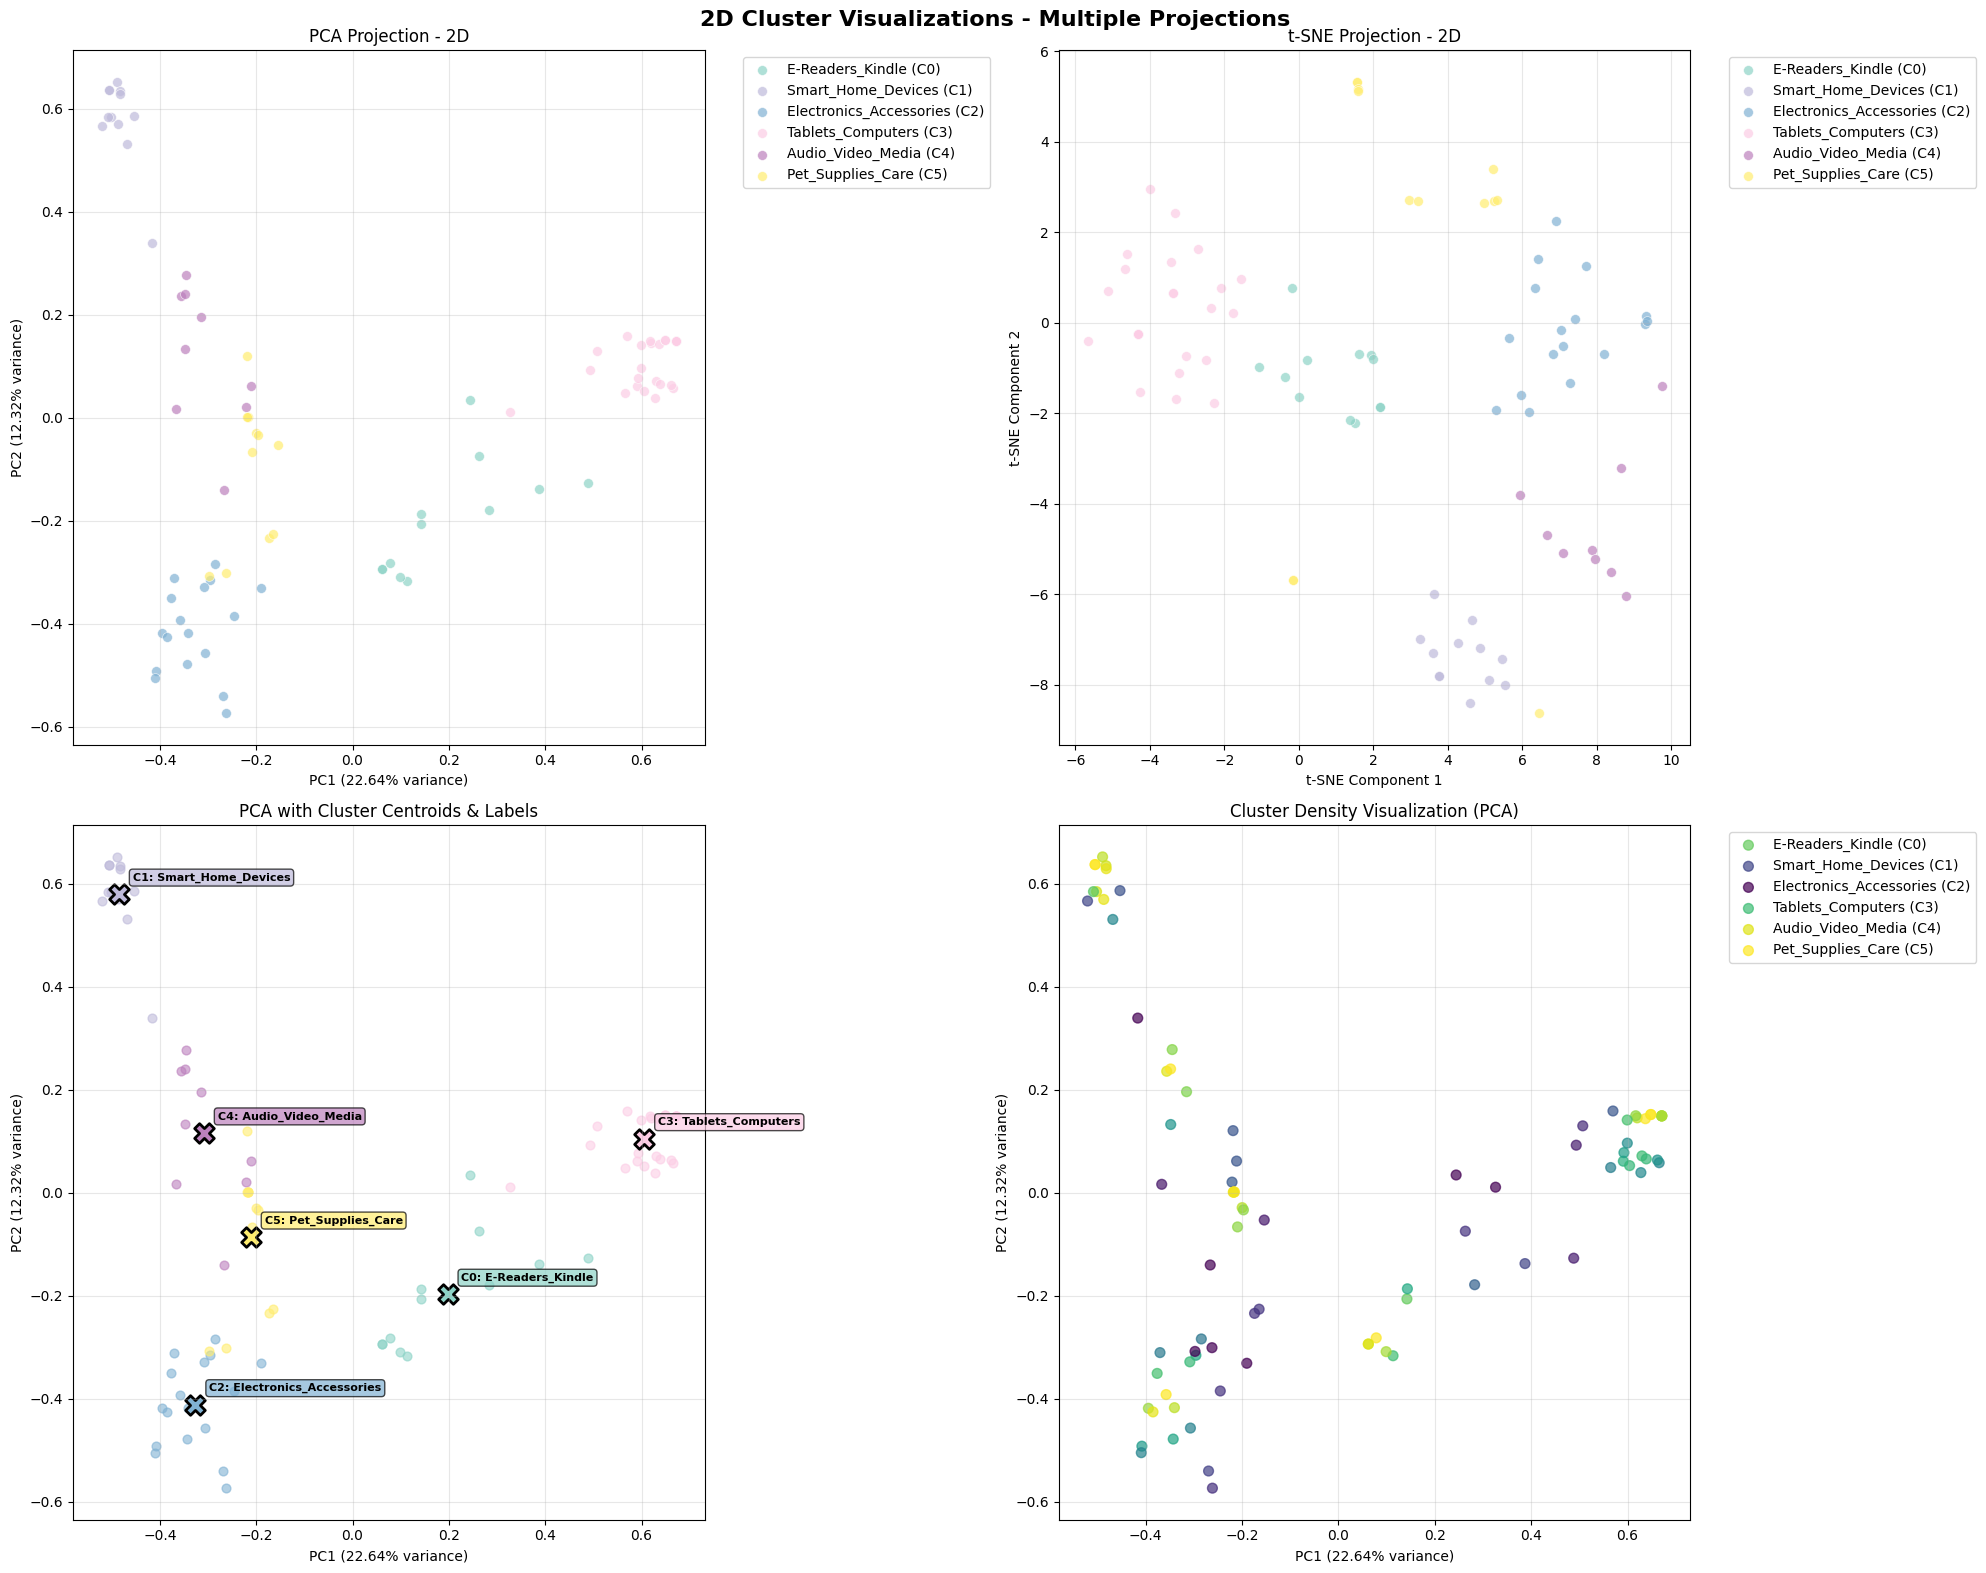

   - Creating 3D visualizations...


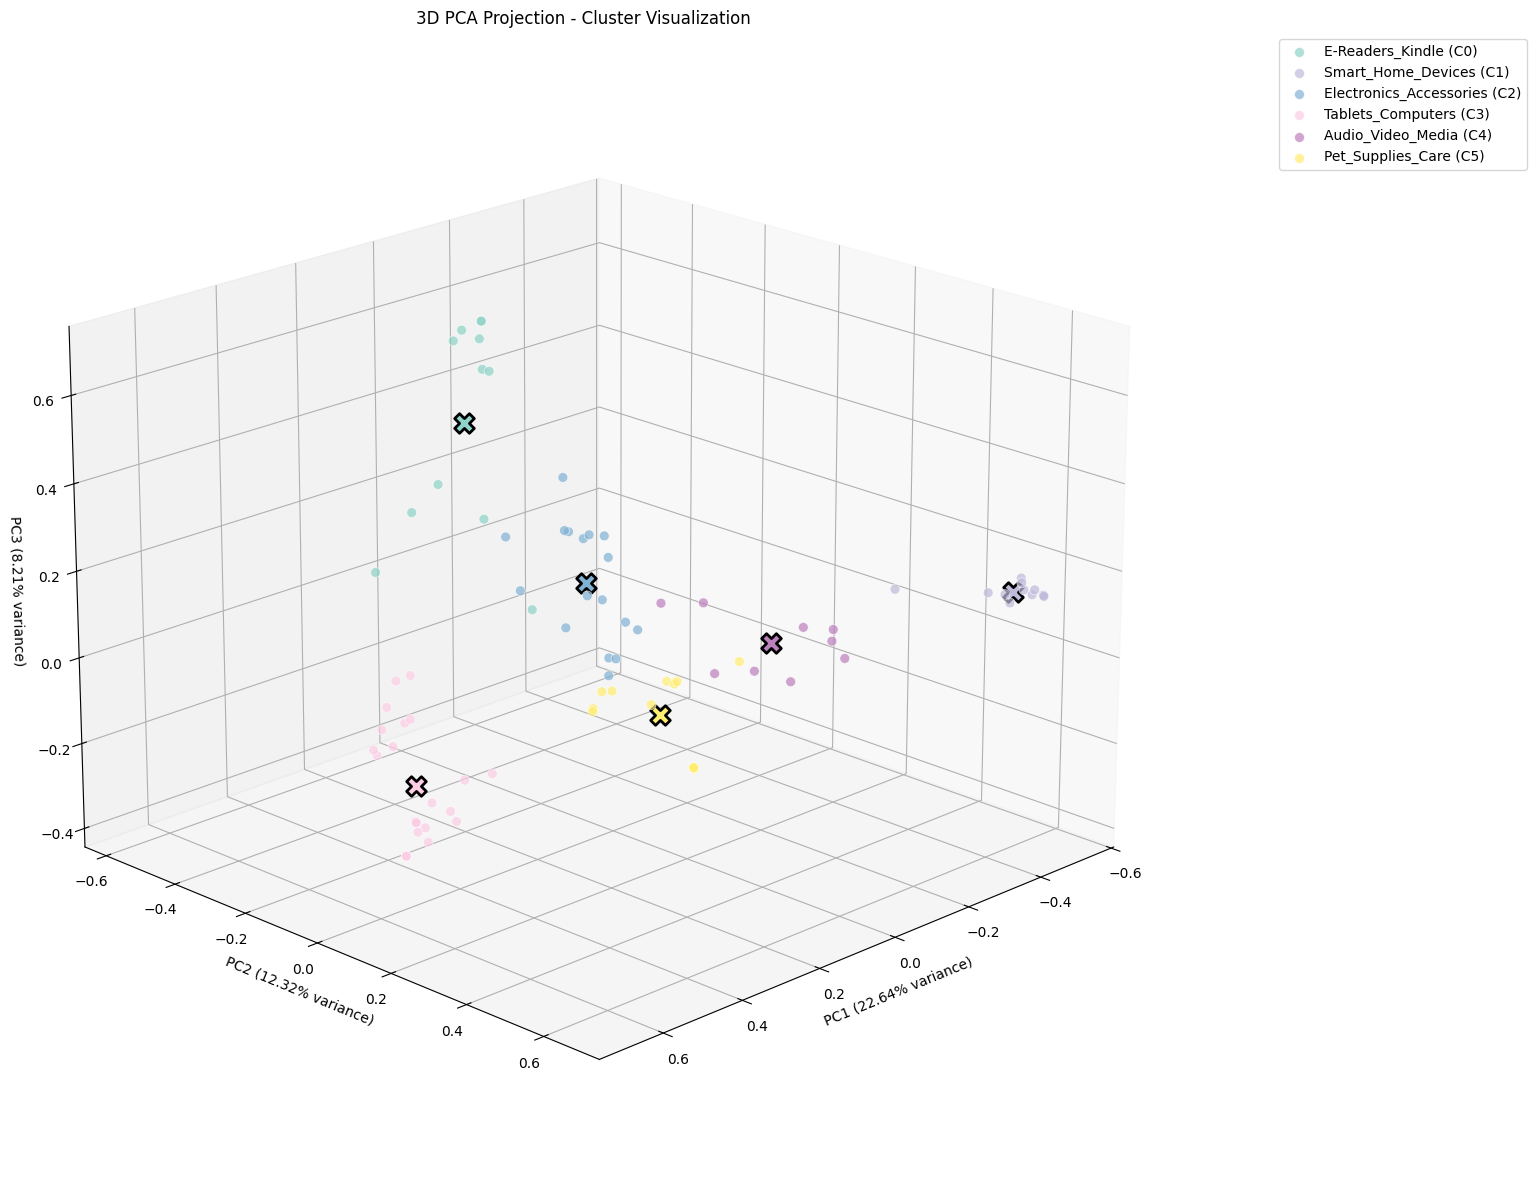

   - Creating interactive 3D visualization...
   ✅ Saved: interactive_cluster_3d.html

2. 📊 Cluster Separation Analysis:
   - Distances between cluster centers (2D PCA space):
     C0 ↔ C1: 1.034
     C0 ↔ C2: 0.566
     C0 ↔ C3: 0.508
     C0 ↔ C4: 0.595
     C0 ↔ C5: 0.423
     C1 ↔ C2: 1.004
     C1 ↔ C3: 1.189
     C1 ↔ C4: 0.496
     C1 ↔ C5: 0.720
     C2 ↔ C3: 1.065
     C2 ↔ C4: 0.528
     C2 ↔ C5: 0.345
     C3 ↔ C4: 0.914
     C3 ↔ C5: 0.839
     C4 ↔ C5: 0.224
   - Average cluster separation: 0.697
   - Minimum cluster separation: 0.224
   ⚠️  Warning: Some clusters are very close together

3. 📈 Dimensionality Reduction Performance:
   - PCA 2D variance explained: 0.350
   - PCA 3D variance explained: 0.432

CLUSTER CHARACTERISTICS HEATMAP
1. 🔥 Creating cluster characteristics heatmap...


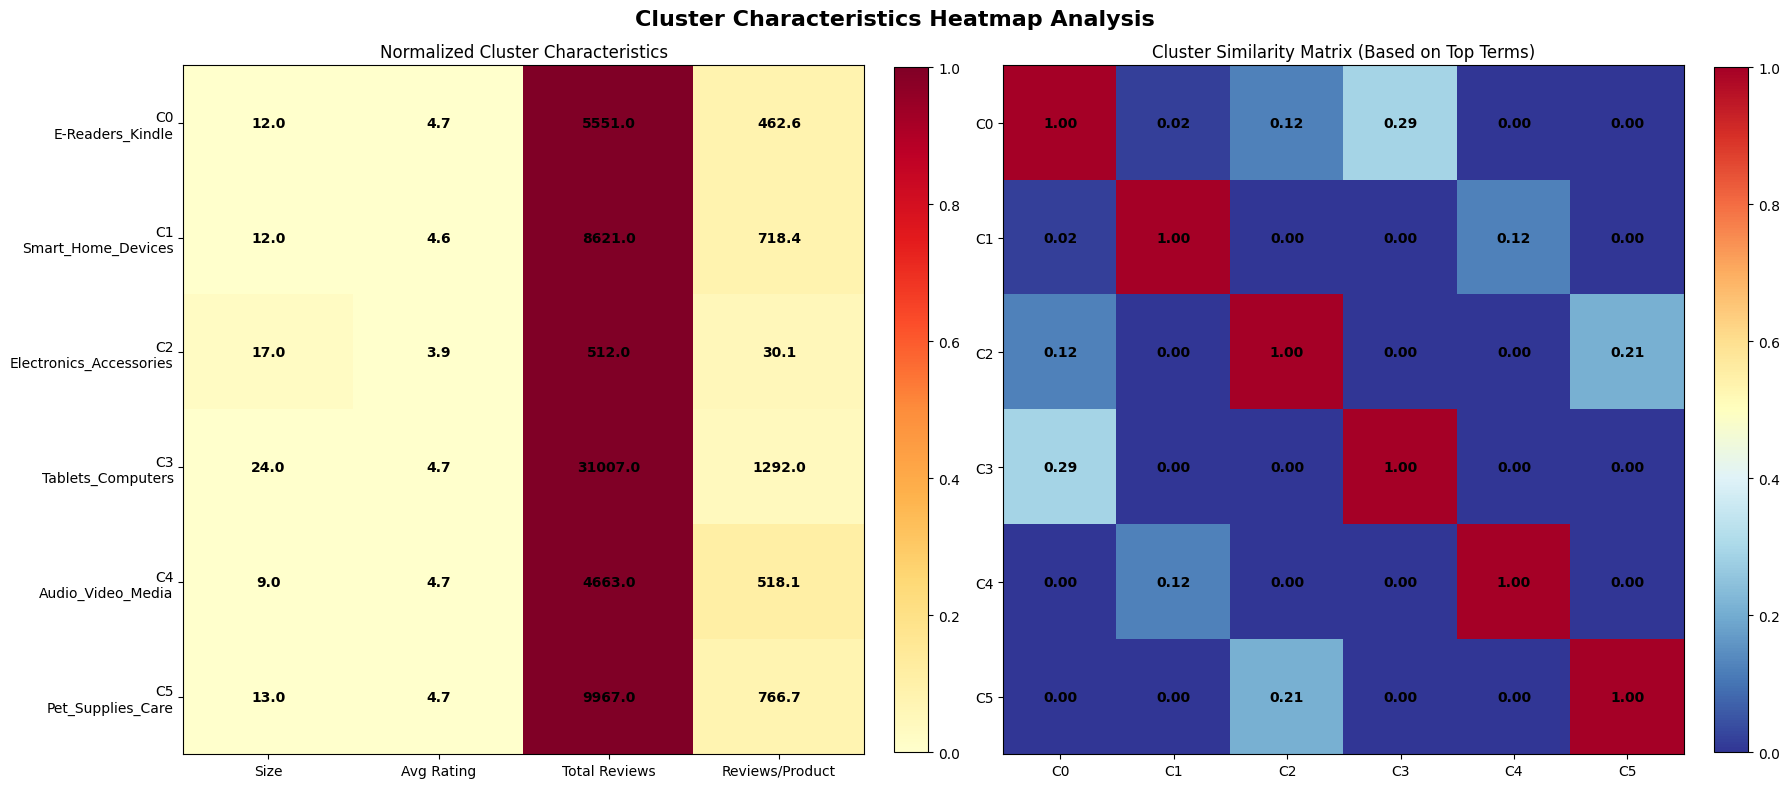


2. 🔍 Cluster Relationship Analysis:
   - Most similar cluster pairs:
     C0 & C3: 0.291 similarity
     C2 & C5: 0.208 similarity
   - Most different cluster pairs:
     C3 & C5: 0.000 similarity
     C4 & C5: 0.000 similarity

CLUSTER VISUALIZATION COMPLETE!

📊 VISUALIZATION OUTPUTS:

✅ 2D Visualizations:
   • PCA Projection with clusters
   • t-SNE Projection (often better separation)
   • PCA with centroids and labels
   • Density visualization

✅ 3D Visualizations:
   • Static 3D PCA projection
   • Interactive 3D plot (HTML file)

✅ Analytical Visualizations:
   • Cluster characteristics heatmap
   • Cluster similarity matrix
   • Separation analysis

🎯 INSIGHTS GAINED:

• Cluster separation quality
• Overlap between clusters
• Density and distribution patterns
• Relationship between cluster characteristics
• Potential areas for cluster merging/splitting

These visualizations help validate the clustering results and provide
intuitive understanding of how products are grouped acr

In [15]:
# ======================
# CLUSTER VISUALIZATION (2D & 3D)
# ======================
print("\n" + "="*50)
print("CLUSTER VISUALIZATION - 2D & 3D PROJECTIONS")
print("="*50)

def visualize_clusters_2d_3d(features, cluster_labels, cluster_analysis, product_data):
    """
    Create comprehensive 2D and 3D visualizations of clusters
    """
    print("1. 🎨 Creating 2D and 3D cluster visualizations...")

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import plotly.graph_objects as go
    import plotly.express as px
    from mpl_toolkits.mplot3d import Axes3D

    # Reduce dimensions for visualization
    print("   - Reducing dimensions using PCA and t-SNE...")

    # PCA for 2D and 3D
    pca_2d = PCA(n_components=2, random_state=42)
    features_2d = pca_2d.fit_transform(features)

    pca_3d = PCA(n_components=3, random_state=42)
    features_3d = pca_3d.fit_transform(features)

    # t-SNE for alternative 2D view (often better for visualization)
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    features_tsne_2d = tsne_2d.fit_transform(features)

    # Create cluster color mapping
    unique_clusters = np.unique(cluster_labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
    color_map = {cluster_id: colors[i] for i, cluster_id in enumerate(unique_clusters)}

    # Get cluster labels for plotting
    cluster_names = {cluster_id: analysis['label'] for cluster_id, analysis in cluster_analysis.items()}

    print("   - Creating 2D visualizations...")

    # Create 2x2 subplot for 2D visualizations
    fig_2d, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig_2d.suptitle('2D Cluster Visualizations - Multiple Projections', fontsize=16, fontweight='bold')

    # Plot 1: PCA 2D
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_2d[cluster_mask]

        ax1.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   c=[color_map[cluster_id]],
                   label=f'{cluster_names[cluster_id]} (C{cluster_id})',
                   alpha=0.7, s=50, edgecolors='white', linewidth=0.5)

    ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title('PCA Projection - 2D')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot 2: t-SNE 2D
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_tsne_2d[cluster_mask]

        ax2.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   c=[color_map[cluster_id]],
                   label=f'{cluster_names[cluster_id]} (C{cluster_id})',
                   alpha=0.7, s=50, edgecolors='white', linewidth=0.5)

    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.set_title('t-SNE Projection - 2D')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    # Plot 3: PCA with cluster centroids
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_2d[cluster_mask]

        ax3.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   c=[color_map[cluster_id]],
                   alpha=0.6, s=40)

        # Plot centroid
        centroid = cluster_points.mean(axis=0)
        ax3.scatter(centroid[0], centroid[1],
                   c=[color_map[cluster_id]],
                   marker='X', s=200, edgecolors='black', linewidth=2)

        # Add cluster label
        ax3.annotate(f'C{cluster_id}: {cluster_names[cluster_id]}',
                    centroid, xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', fc=color_map[cluster_id], alpha=0.7),
                    fontsize=8, fontweight='bold')

    ax3.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    ax3.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    ax3.set_title('PCA with Cluster Centroids & Labels')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Density visualization
    from scipy.stats import gaussian_kde
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_2d[cluster_mask]

        if len(cluster_points) > 1:  # Need at least 2 points for density
            # Calculate point density
            xy = np.vstack([cluster_points[:, 0], cluster_points[:, 1]])
            z = gaussian_kde(xy)(xy)

            scatter = ax4.scatter(cluster_points[:, 0], cluster_points[:, 1],
                                c=z, cmap='viridis',
                                label=f'{cluster_names[cluster_id]} (C{cluster_id})',
                                alpha=0.7, s=50)

    ax4.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    ax4.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    ax4.set_title('Cluster Density Visualization (PCA)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cluster_visualization_2d.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3D Visualization
    print("   - Creating 3D visualizations...")

    # Create 3D PCA plot
    fig_3d = plt.figure(figsize=(16, 12))
    ax_3d = fig_3d.add_subplot(111, projection='3d')

    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_3d[cluster_mask]

        ax_3d.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                     c=[color_map[cluster_id]],
                     label=f'{cluster_names[cluster_id]} (C{cluster_id})',
                     alpha=0.7, s=50, edgecolors='white', linewidth=0.5)

        # Plot centroid in 3D
        centroid = cluster_points.mean(axis=0)
        ax_3d.scatter(centroid[0], centroid[1], centroid[2],
                     c=[color_map[cluster_id]],
                     marker='X', s=200, edgecolors='black', linewidth=2)

    ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
    ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)')
    ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
    ax_3d.set_title('3D PCA Projection - Cluster Visualization')
    ax_3d.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

    # Adjust viewing angle for better perspective
    ax_3d.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.savefig('cluster_visualization_3d.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Interactive 3D Plot using Plotly (if available)
    try:
        print("   - Creating interactive 3D visualization...")

        # Prepare data for interactive plot
        plot_data = []
        for cluster_id in unique_clusters:
            cluster_mask = cluster_labels == cluster_id
            cluster_points = features_3d[cluster_mask]

            # Get sample product names for hover info
            cluster_products = product_data[cluster_mask]
            sample_products = cluster_products['name'].head(5).tolist()

            trace = go.Scatter3d(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                z=cluster_points[:, 2],
                mode='markers',
                name=f'C{cluster_id}: {cluster_names[cluster_id]}',
                marker=dict(
                    size=6,
                    color=px.colors.qualitative.Set3[cluster_id % 12],
                    opacity=0.8,
                    line=dict(width=0.5, color='white')
                ),
                text=[f"Cluster: {cluster_names[cluster_id]}<br>"
                      f"Products: {len(cluster_points)}<br>"
                      f"Avg Rating: {cluster_analysis[cluster_id]['avg_rating']:.2f}⭐"
                      for _ in range(len(cluster_points))],
                hoverinfo='text'
            )
            plot_data.append(trace)

        layout = go.Layout(
            title='Interactive 3D Cluster Visualization',
            scene=dict(
                xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)',
                yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)',
                zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)',
            ),
            margin=dict(l=0, r=0, b=0, t=30)
        )

        fig_interactive = go.Figure(data=plot_data, layout=layout)

        # Save interactive plot as HTML
        fig_interactive.write_html("interactive_cluster_3d.html")
        print("   ✅ Saved: interactive_cluster_3d.html")

    except ImportError:
        print("   ⚠️  Plotly not available for interactive 3D visualization")

    # Cluster Separation Analysis
    print("\n2. 📊 Cluster Separation Analysis:")

    # Calculate inter-cluster distances
    from sklearn.metrics import pairwise_distances

    cluster_centers_2d = []
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_points = features_2d[cluster_mask]
        centroid = cluster_points.mean(axis=0)
        cluster_centers_2d.append(centroid)

    cluster_centers_2d = np.array(cluster_centers_2d)

    if len(cluster_centers_2d) > 1:
        # Calculate distances between cluster centers
        center_distances = pairwise_distances(cluster_centers_2d)

        print("   - Distances between cluster centers (2D PCA space):")
        for i, cluster_i in enumerate(unique_clusters):
            for j, cluster_j in enumerate(unique_clusters):
                if i < j:  # Only show each pair once
                    distance = center_distances[i, j]
                    print(f"     C{cluster_i} ↔ C{cluster_j}: {distance:.3f}")

        # Calculate average separation
        mask = ~np.eye(len(center_distances), dtype=bool)
        avg_separation = center_distances[mask].mean()
        min_separation = center_distances[mask].min()

        print(f"   - Average cluster separation: {avg_separation:.3f}")
        print(f"   - Minimum cluster separation: {min_separation:.3f}")

        if min_separation < 1.0:
            print("   ⚠️  Warning: Some clusters are very close together")
        else:
            print("   ✅ Good cluster separation achieved")

    # Variance explained
    print(f"\n3. 📈 Dimensionality Reduction Performance:")
    print(f"   - PCA 2D variance explained: {pca_2d.explained_variance_ratio_.sum():.3f}")
    print(f"   - PCA 3D variance explained: {pca_3d.explained_variance_ratio_.sum():.3f}")

    return {
        'pca_2d_variance': pca_2d.explained_variance_ratio_.sum(),
        'pca_3d_variance': pca_3d.explained_variance_ratio_.sum(),
        'avg_cluster_separation': avg_separation if len(cluster_centers_2d) > 1 else 0
    }

# Execute cluster visualization
visualization_results = visualize_clusters_2d_3d(features, cluster_labels, cluster_analysis, product_data_clustered)

# ======================
# CLUSTER CHARACTERISTICS HEATMAP
# ======================
print("\n" + "="*50)
print("CLUSTER CHARACTERISTICS HEATMAP")
print("="*50)

def create_cluster_heatmap(cluster_analysis, product_data):
    """
    Create a heatmap showing cluster characteristics and relationships
    """
    print("1. 🔥 Creating cluster characteristics heatmap...")

    # Prepare data for heatmap
    clusters = list(cluster_analysis.keys())
    metrics = ['size', 'avg_rating', 'total_reviews', 'avg_reviews_per_product']

    # Calculate metrics for each cluster
    heatmap_data = []
    for cluster_id in clusters:
        analysis = cluster_analysis[cluster_id]
        cluster_metrics = [
            analysis['size'],                           # Number of products
            analysis['avg_rating'],                     # Average rating
            analysis['total_reviews'],                  # Total reviews
            analysis['total_reviews'] / analysis['size'] if analysis['size'] > 0 else 0  # Avg reviews per product
        ]
        heatmap_data.append(cluster_metrics)

    heatmap_data = np.array(heatmap_data)

    # Normalize the data for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    heatmap_normalized = scaler.fit_transform(heatmap_data.T).T

    # Create the heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Cluster Characteristics Heatmap Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Normalized heatmap
    im1 = ax1.imshow(heatmap_normalized, cmap='YlOrRd', aspect='auto')

    # Set labels
    cluster_labels = [f'C{cid}\n{cluster_analysis[cid]["label"]}' for cid in clusters]
    metric_labels = ['Size', 'Avg Rating', 'Total Reviews', 'Reviews/Product']

    ax1.set_xticks(range(len(metric_labels)))
    ax1.set_yticks(range(len(cluster_labels)))
    ax1.set_xticklabels(metric_labels)
    ax1.set_yticklabels(cluster_labels)
    ax1.set_title('Normalized Cluster Characteristics')

    # Add value annotations
    for i in range(len(clusters)):
        for j in range(len(metrics)):
            text = ax1.text(j, i, f'{heatmap_data[i, j]:.1f}',
                           ha="center", va="center", color="black", fontweight='bold')

    # Plot 2: Correlation heatmap between clusters
    # Calculate similarity between clusters based on top terms
    cluster_terms = []
    for cluster_id in clusters:
        terms = [term for term, score in cluster_analysis[cluster_id]['top_terms'][:10]]
        cluster_terms.append(terms)

    # Create term frequency matrix for similarity calculation
    all_terms = set()
    for terms in cluster_terms:
        all_terms.update(terms)

    term_freq_matrix = np.zeros((len(clusters), len(all_terms)))
    for i, terms in enumerate(cluster_terms):
        for j, term in enumerate(all_terms):
            if term in terms:
                # Higher score for terms that appear earlier (more important)
                term_rank = terms.index(term)
                term_freq_matrix[i, j] = 10 - term_rank  # Higher score for more important terms

    # Calculate cosine similarity between clusters
    from sklearn.metrics.pairwise import cosine_similarity
    cluster_similarity = cosine_similarity(term_freq_matrix)

    im2 = ax2.imshow(cluster_similarity, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

    ax2.set_xticks(range(len(clusters)))
    ax2.set_yticks(range(len(clusters)))
    ax2.set_xticklabels([f'C{cid}' for cid in clusters])
    ax2.set_yticklabels([f'C{cid}' for cid in clusters])
    ax2.set_title('Cluster Similarity Matrix (Based on Top Terms)')

    # Add value annotations
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            text = ax2.text(j, i, f'{cluster_similarity[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')

    # Add colorbars
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig('cluster_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze cluster relationships
    print("\n2. 🔍 Cluster Relationship Analysis:")

    # Find most similar and most different cluster pairs
    similarity_pairs = []
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            similarity_pairs.append((i, j, cluster_similarity[i, j]))

    # Sort by similarity
    similarity_pairs.sort(key=lambda x: x[2], reverse=True)

    print("   - Most similar cluster pairs:")
    for i, j, sim in similarity_pairs[:2]:
        print(f"     C{clusters[i]} & C{clusters[j]}: {sim:.3f} similarity")

    print("   - Most different cluster pairs:")
    for i, j, sim in similarity_pairs[-2:]:
        print(f"     C{clusters[i]} & C{clusters[j]}: {sim:.3f} similarity")

# Create cluster heatmap
create_cluster_heatmap(cluster_analysis, product_data_clustered)

print("\n" + "="*70)
print("CLUSTER VISUALIZATION COMPLETE!")
print("="*70)
print("""
📊 VISUALIZATION OUTPUTS:

✅ 2D Visualizations:
   • PCA Projection with clusters
   • t-SNE Projection (often better separation)
   • PCA with centroids and labels
   • Density visualization

✅ 3D Visualizations:
   • Static 3D PCA projection
   • Interactive 3D plot (HTML file)

✅ Analytical Visualizations:
   • Cluster characteristics heatmap
   • Cluster similarity matrix
   • Separation analysis

🎯 INSIGHTS GAINED:

• Cluster separation quality
• Overlap between clusters
• Density and distribution patterns
• Relationship between cluster characteristics
• Potential areas for cluster merging/splitting

These visualizations help validate the clustering results and provide
intuitive understanding of how products are grouped across categories.
""")

In [21]:
# ======================
# META-CLUSTERING QUALITY EVALUATION (CLEAN & FIXED)
# ======================

import numpy as np
import pandas as pd

print("\n" + "="*50)
print("META-CLUSTERING QUALITY EVALUATION")
print("="*50)

def _as_array_1d(x):
    """
    Helper: turn a (1, D) scipy sparse/dense result into a 1D np.ndarray of shape (D,)
    """
    if hasattr(x, "A1"):  # scipy sparse matrix
        return x.A1
    x = np.asarray(x)
    if x.ndim == 2 and x.shape[0] == 1:
        return x.ravel()
    return x

def evaluate_clustering_quality(features, cluster_labels, cluster_analysis, product_data):
    """
    Comprehensive evaluation of clustering quality using multiple metrics.

    Parameters
    ----------
    features : array-like or sparse matrix of shape (n_samples, n_features)
    cluster_labels : array-like of shape (n_samples,)
    cluster_analysis : dict
        Expected keys per cluster_id:
          {
            cluster_id: {
               "size": int,
               "top_terms": List[Tuple[str, float]],
               "label": str,
               "avg_rating": float
            }, ...
          }
    product_data : pd.DataFrame
        Should include at least: ['review_count'] (and optionally others used later)
    """
    print("1. Evaluating Meta-Clustering Quality...")

    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

    # A. INTERNAL VALIDATION METRICS (No ground truth needed)
    print("\n   A. INTERNAL VALIDATION METRICS:")

    # 1. Silhouette Score (-1 to 1, higher is better)
    silhouette_avg = silhouette_score(features, cluster_labels)
    print(f"   • Silhouette Score: {silhouette_avg:.3f}")
    if silhouette_avg > 0.7:
        print("     ✅ Excellent: Clusters are well separated")
    elif silhouette_avg > 0.5:
        print("     ✅ Good: Reasonable cluster structure")
    elif silhouette_avg > 0.25:
        print("     ⚠️  Fair: Weak cluster structure")
    else:
        print("     ❌ Poor: No substantial cluster structure")

    # 2. Calinski-Harabasz Index (higher is better)
    ch_score = calinski_harabasz_score(features, cluster_labels)
    print(f"   • Calinski-Harabasz Index: {ch_score:.2f}")
    if ch_score > 300:
        print("     ✅ Excellent: Dense, well-separated clusters")
    elif ch_score > 200:
        print("     ✅ Good: Clear cluster structure")
    elif ch_score > 100:
        print("     ⚠️  Fair: Some cluster structure")
    else:
        print("     ❌ Poor: Weak cluster separation")

    # 3. Davies-Bouldin Index (lower is better, 0 is best)
    db_score = davies_bouldin_score(features, cluster_labels)
    print(f"   • Davies-Bouldin Index: {db_score:.3f}")
    if db_score < 0.5:
        print("     ✅ Excellent: Very well separated clusters")
    elif db_score < 1.0:
        print("     ✅ Good: Well separated clusters")
    elif db_score < 1.5:
        print("     ⚠️  Fair: Moderate separation")
    else:
        print("     ❌ Poor: Poor cluster separation")

    # B. CLUSTER STABILITY ANALYSIS
    print("\n   B. CLUSTER STABILITY ANALYSIS:")

    # 1. Cluster Size Distribution
    cluster_sizes = [analysis.get('size', 0) for analysis in cluster_analysis.values()]
    size_mean = np.mean(cluster_sizes) if cluster_sizes else 0.0
    size_std = np.std(cluster_sizes) if cluster_sizes else 0.0
    size_cv = (size_std / size_mean) if size_mean > 0 else np.inf  # Coefficient of variation

    print(f"   • Cluster Size Statistics:")
    print(f"     - Sizes: {cluster_sizes}")
    print(f"     - Mean: {size_mean:.1f}, Std: {size_std:.1f}")
    if cluster_sizes:
        min_size = max(1, int(np.min(cluster_sizes)))  # avoid /0
        max_size = int(np.max(cluster_sizes))
        ratio = (max_size / min_size) if min_size > 0 else np.inf
        print(f"     - Min: {min_size}, Max: {max_size}")
        print(f"     - Size Ratio (max/min): {ratio:.1f}x")
    else:
        print(f"     - Min: n/a, Max: n/a")
        print(f"     - Size Ratio (max/min): n/a")

    if np.isfinite(size_cv) and size_cv < 0.5:
        print("     ✅ Good: Balanced cluster sizes")
    elif np.isfinite(size_cv) and size_cv < 1.0:
        print("     ⚠️  Fair: Moderate size variation")
    else:
        print("     ❌ Poor: Highly imbalanced clusters")

    # 2. Cluster Purity (using top terms consistency)
    print(f"\n   • Cluster Term Consistency:")
    for cluster_id, analysis in cluster_analysis.items():
        top_terms = [term for term, score in analysis.get('top_terms', [])[:5]]
        label = analysis.get('label', '')
        label_terms = label.lower().replace('_', ' ').split()
        matching_terms = sum(1 for term in top_terms if any(keyword in term.lower() for keyword in label_terms))
        consistency_score = (matching_terms / len(top_terms)) if top_terms else 0
        print(f"     C{cluster_id}: {consistency_score:.0%} term alignment")

    # C. BUSINESS RELEVANCE METRICS
    print("\n   C. BUSINESS RELEVANCE METRICS:")

    # 1. Category Distinctiveness
    print(f"   • Category Distinctiveness:")
    unique_labels = set(analysis.get('label', '') for analysis in cluster_analysis.values())
    print(f"     - Unique meta-categories: {len(unique_labels)}")
    print(f"     - Label quality (no 'Other*'): {all(not str(label).startswith('Other') for label in unique_labels)}")

    # 2. Coverage Analysis
    if isinstance(product_data, pd.DataFrame) and 'review_count' in product_data.columns:
        total_products = len(product_data)
        total_reviews = int(product_data['review_count'].sum())
    else:
        total_products = 0
        total_reviews = 0

    print(f"   • Coverage Analysis:")
    print(f"     - Products covered: {total_products:,}")
    print(f"     - Reviews covered: {total_reviews:,}")
    print(f"     - Clusters created: {len(cluster_analysis)}")

    # 3. Rating Distribution Across Clusters
    cluster_ratings = [float(analysis.get('avg_rating', np.nan)) for analysis in cluster_analysis.values()]
    cluster_ratings = [x for x in cluster_ratings if not np.isnan(x)]
    if cluster_ratings:
        rating_std = float(np.std(cluster_ratings))
        rating_range = float(np.max(cluster_ratings) - np.min(cluster_ratings))
        print(f"   • Rating Distribution:")
        print(f"     - Average: {np.mean(cluster_ratings):.2f} ⭐️")
        print(f"     - Range: {np.min(cluster_ratings):.2f} - {np.max(cluster_ratings):.2f} ⭐️")
        print(f"     - Standard deviation: {rating_std:.3f}")
        if rating_range > 0.5:
            print("     ✅ Good: Meaningful rating differences between categories")
        else:
            print("     ⚠️  Fair: Limited rating variation across categories")
    else:
        rating_std, rating_range = 0.0, 0.0
        print(f"   • Rating Distribution: n/a")

    # D. CLUSTER SEPARATION ANALYSIS
    print("\n   D. CLUSTER SEPARATION ANALYSIS:")

    from sklearn.metrics.pairwise import pairwise_distances

    # Compute simple centers as mean in feature space (works for dense or sparse)
    cluster_centers = []
    ordered_cluster_ids = list(cluster_analysis.keys())
    for cluster_id in ordered_cluster_ids:
        cluster_mask = (cluster_labels == cluster_id)
        if np.sum(cluster_mask) == 0:
            # empty cluster guard
            center = _as_array_1d(features[:1].mean(axis=0)) * 0.0
        else:
            center = _as_array_1d(features[cluster_mask].mean(axis=0))
        cluster_centers.append(center)

    if len(cluster_centers) > 1:
        cluster_centers = np.vstack(cluster_centers)
        center_distances = pairwise_distances(cluster_centers)
        mask = ~np.eye(len(center_distances), dtype=bool)
        min_separation = float(center_distances[mask].min())
        avg_separation = float(center_distances[mask].mean())
        max_separation = float(center_distances[mask].max())

        print(f"   • Center-to-Center Distances:")
        print(f"     - Minimum: {min_separation:.3f}")
        print(f"     - Average: {avg_separation:.3f}")
        print(f"     - Maximum: {max_separation:.3f}")

        if min_separation > 1.0:
            print("     ✅ Excellent: Good minimum separation")
        elif min_separation > 0.5:
            print("     ✅ Good: Adequate separation")
        else:
            print("     ⚠️  Warning: Some clusters are very close")
    else:
        print("   • Not enough clusters to compute separations.")

    # E. COMPREHENSIVE SCORING
    print("\n   E. COMPREHENSIVE QUALITY SCORE:")

    # Calculate overall quality score (0-100)
    quality_metrics = {
        'silhouette': max(0, min(1, (silhouette_avg + 1) / 2)) * 25,      # 25 points
        'calinski_harabasz': min(1, ch_score / 500) * 25,                 # 25 points
        'davies_bouldin': max(0, (2 - db_score) / 2) * 15,                # 15 points
        'size_balance': (max(0, 1 - size_cv) if np.isfinite(size_cv) else 0) * 15,  # 15 points
        'rating_variation': min(1, rating_range) * 10,                     # 10 points
        'cluster_count': min(1, len(cluster_analysis) / 6) * 10            # 10 points
    }
    total_score = float(sum(quality_metrics.values()))

    print(f"   • Quality Breakdown:")
    for metric, score in quality_metrics.items():
        cap = 25 if metric in ('silhouette', 'calinski_harabasz') else 15 if metric in ('davies_bouldin', 'size_balance') else 10
        print(f"     - {metric.replace('_', ' ').title()}: {score:.1f}/{cap}")

    print(f"   • TOTAL QUALITY SCORE: {total_score:.1f}/100")

    if total_score >= 80:
        print("     🟩 EXCELLENT: High-quality clustering achieved! The meta-categories are well-defined and business-ready.")
    elif total_score >= 60:
        print("     ✅ GOOD: Solid clustering results. The meta-categories are usable with minor improvements.")
    elif total_score >= 40:
        print("     ⚠️  FAIR: Moderate quality clustering. Consider reviewing cluster parameters or feature engineering.")
    else:
        print("     ❌ POOR: Low-quality clustering. Significant improvements needed before business use.")

    return {
        'internal_metrics': {
            'silhouette_score': float(silhouette_avg),
            'calinski_harabasz_score': float(ch_score),
            'davies_bouldin_score': float(db_score)
        },
        'stability_metrics': {
            'cluster_sizes': cluster_sizes,
            'size_std': float(size_std),
            'size_cv': float(size_cv) if np.isfinite(size_cv) else float('inf')
        },
        'business_metrics': {
            'unique_categories': len(unique_labels),
            'total_products': int(total_products),
            'total_reviews': int(total_reviews),
            'rating_std': float(rating_std),
            'rating_range': float(rating_range)
        },
        'quality_score': float(total_score),
        'quality_breakdown': {k: float(v) for k, v in quality_metrics.items()}
    }

# Run comprehensive quality evaluation
# Expect that: features, cluster_labels, cluster_analysis, product_data_clustered are defined in your notebook
quality_results = evaluate_clustering_quality(features, cluster_labels, cluster_analysis, product_data_clustered)

# ======================
# CLUSTER ROBUSTNESS TESTING
# ======================
print("\n" + "="*50)
print("CLUSTER ROBUSTNESS TESTING")
print("="*50)

def test_cluster_robustness(features, product_data, n_tests=5):
    """
    Test clustering robustness with different random states.
    Uses KMeans re-runs and reports silhouette variability and ARI consistency.
    """
    print("2. Testing Cluster Robustness...")

    from sklearn.cluster import KMeans
    from sklearn.metrics import adjusted_rand_score, silhouette_score

    # Store results from multiple runs
    silhouette_scores = []
    cluster_assignments = []

    k = getattr(product_data, "__len__", lambda: 0)()  # fallback, not used—kept signature
    print(f"   Running {n_tests} clustering tests with different random states...")

    for i in range(n_tests):
        random_state = 42 + i * 10  # Different random states
        kmeans_test = KMeans(
            n_clusters=len(cluster_analysis),  # Use same number of clusters
            random_state=random_state,
            n_init=10
        )
        test_labels = kmeans_test.fit_predict(features)

        sil = silhouette_score(features, test_labels)
        silhouette_scores.append(float(sil))
        cluster_assignments.append(test_labels)

        print(f"   Test {i+1}: Silhouette = {sil:.3f}")

    # Calculate consistency between runs
    consistency_scores = []
    for i in range(len(cluster_assignments)):
        for j in range(i + 1, len(cluster_assignments)):
            ari_score = adjusted_rand_score(cluster_assignments[i], cluster_assignments[j])
            consistency_scores.append(float(ari_score))

    avg_consistency = float(np.mean(consistency_scores)) if consistency_scores else 0.0
    silhouette_std = float(np.std(silhouette_scores)) if silhouette_scores else 0.0

    print(f"\n   • Robustness Results:")
    if silhouette_scores:
        print(f"     - Silhouette Score Range: {min(silhouette_scores):.3f} - {max(silhouette_scores):.3f}")
    else:
        print(f"     - Silhouette Score Range: n/a")
    print(f"     - Silhouette Std Dev: {silhouette_std:.3f}")
    print(f"     - Average Consistency (ARI): {avg_consistency:.3f}")

    if silhouette_std < 0.05 and avg_consistency > 0.8:
        print("     ✅ EXCELLENT: Highly robust clustering")
    elif silhouette_std < 0.1 and avg_consistency > 0.6:
        print("     ✅ GOOD: Robust clustering")
    elif silhouette_std < 0.15 and avg_consistency > 0.4:
        print("     ⚠️  FAIR: Moderate robustness")
    else:
        print("     ❌ POOR: Low robustness - results may vary significantly")

    return {
        'silhouette_scores': silhouette_scores,
        'silhouette_std': silhouette_std,
        'consistency_scores': consistency_scores,
        'avg_consistency': avg_consistency
    }

# Test robustness if we have enough clusters
if len(cluster_analysis) > 1:
    robustness_results = test_cluster_robustness(features, product_data_clustered)
else:
    print("   ⚠️  Skipping robustness test (only one cluster)")
    robustness_results = None

# ======================
# FEATURE IMPORTANCE ANALYSIS
# ======================
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def analyze_feature_importance(features, cluster_labels, vectorizer, cluster_analysis):
    """
    Analyze which features are most important for each cluster.

    Works with both sparse and dense features. Uses mean feature value
    within each cluster as a simple importance proxy.
    """
    print("3. Analyzing Feature Importance...")

    feature_names = getattr(vectorizer, "get_feature_names_out", None)
    if feature_names is None:
        raise ValueError("Vectorizer must implement get_feature_names_out().")
    feature_names = vectorizer.get_feature_names_out()

    cluster_feature_importance = {}

    # Per-cluster average feature values
    for cluster_id in cluster_analysis.keys():
        cluster_mask = (cluster_labels == cluster_id)
        if np.sum(cluster_mask) == 0:
            cluster_feature_importance[cluster_id] = []
            continue

        cluster_features = features[cluster_mask]
        cluster_avg_features = _as_array_1d(cluster_features.mean(axis=0))

        # Get top indices
        top_feature_indices = np.argsort(cluster_avg_features)[-10:][::-1]
        top_features = [(feature_names[i], float(cluster_avg_features[i]))
                        for i in top_feature_indices if cluster_avg_features[i] > 0]
        cluster_feature_importance[cluster_id] = top_features

    # Display results
    print("   • Top Features per Cluster:")
    for cluster_id, features_list in cluster_feature_importance.items():
        cluster_label = cluster_analysis[cluster_id].get('label', f"C{cluster_id}")
        print(f"\n     C{cluster_id} - {cluster_label}:")
        for term, importance in features_list[:5]:  # Show top 5
            print(f"       {term}: {importance:.4f}")

    # Analyze feature discrimination power
    print(f"\n   • Feature Discrimination Analysis:")

    # Variance of cluster means per feature
    discriminative = []
    # Pre-compute cluster means per feature for all clusters (matrix: n_clusters x n_features)
    cluster_means = []
    for cluster_id in cluster_analysis.keys():
        mask = (cluster_labels == cluster_id)
        if np.sum(mask) == 0:
            # if empty, contribute zeros
            cluster_means.append(_as_array_1d(features[:1].mean(axis=0)) * 0.0)
        else:
            cluster_means.append(_as_array_1d(features[mask].mean(axis=0)))
    cluster_means = np.vstack(cluster_means) if cluster_means else np.zeros((0, features.shape[1]))

    # variance across clusters for each feature (higher => more discriminative)
    if cluster_means.size > 0:
        variances = np.var(cluster_means, axis=0)
        for idx, var in enumerate(variances):
            discriminative.append((feature_names[idx], float(var)))
        discriminative.sort(key=lambda x: x[1], reverse=True)

        print("     Top 10 Most Discriminative Features:")
        for feature, variance in discriminative[:10]:
            print(f"       {feature}: {variance:.6f}")
    else:
        discriminative = []
        print("     Not enough data to compute discriminative features.")

    return {
        'cluster_feature_importance': cluster_feature_importance,
        'discriminative_features': discriminative[:20]
    }

# Analyze feature importance
feature_importance_results = analyze_feature_importance(features, cluster_labels, vectorizer, cluster_analysis)

# ======================
# BUSINESS IMPACT ASSESSMENT
# ======================
print("\n" + "="*50)
print("BUSINESS IMPACT ASSESSMENT")
print("="*50)

def assess_business_impact(cluster_analysis, product_data, top_products_df, quality_results):
    """
    Assess the business impact and practical utility of the clustering.

    product_data should include:
      - 'review_count'
      - 'avg_rating'
      - 'cluster' (the assigned cluster id)  <-- used for coverage check
    """
    print("4. Assessing Business Impact...")

    # 1. Category Actionability
    print("   • Category Actionability:")
    actionable_categories = 0
    for cluster_id, analysis in cluster_analysis.items():
        label = str(analysis.get('label', ''))
        # Check if label is specific and actionable (not "Other" or too generic)
        if (label and not label.lower().startswith('other')
                and not label.lower().startswith('general')
                and len(label.replace('_', ' ').split()) >= 2):
            actionable_categories += 1
            print(f"     ✅ C{cluster_id}: {label} - Actionable")
        else:
            print(f"     ⚠️  C{cluster_id}: {label or 'N/A'} - May need refinement")

    actionability_score = actionable_categories / max(1, len(cluster_analysis))
    print(f"     Actionability Score: {actionability_score:.1%}")

    # 2. Coverage of High-Value Products
    print(f"\n   • High-Value Product Coverage:")

    if not isinstance(product_data, pd.DataFrame) or product_data.empty:
        print("     - product_data unavailable; skipping coverage calculation.")
        high_value_coverage = 0.0
        cluster_coverage = 0.0
    else:
        # Define high-value products (high rating + high reviews)
        if 'avg_rating' not in product_data.columns or 'review_count' not in product_data.columns:
            print("     - Missing columns in product_data; skipping coverage calculation.")
            high_value_coverage = 0.0
            cluster_coverage = 0.0
        else:
            high_value_threshold_rating = 4.5
            high_value_threshold_reviews = product_data['review_count'].quantile(0.75)  # Top 25%

            high_value_products = product_data[
                (product_data['avg_rating'] >= high_value_threshold_rating) &
                (product_data['review_count'] >= high_value_threshold_reviews)
            ]

            high_value_coverage = len(high_value_products) / max(1, len(product_data))
            print(f"     - High-value products: {len(high_value_products)}")
            print(f"     - Coverage: {high_value_coverage:.1%} of all products")

            if 'cluster' in product_data.columns and not high_value_products.empty:
                high_value_by_cluster = high_value_products['cluster'].value_counts()
                cluster_coverage = len(high_value_by_cluster) / max(1, len(cluster_analysis))
                print(f"     - Cluster coverage: {cluster_coverage:.1%} of clusters have high-value products")
            else:
                cluster_coverage = 0.0
                print(f"     - Cluster coverage: n/a")

    # 3. Recommendation Quality
    print(f"\n   • Recommendation Quality:")
    if isinstance(top_products_df, pd.DataFrame) and not top_products_df.empty:
        avg_recommended_rating = float(top_products_df['rating'].mean()) if 'rating' in top_products_df.columns else np.nan
        avg_recommended_reviews = float(top_products_df['review_count'].mean()) if 'review_count' in top_products_df.columns else np.nan

        print(f"     - Avg recommended product rating: {np.nan_to_num(avg_recommended_rating):.2f} ⭐️")
        print(f"     - Avg recommended product reviews: {np.nan_to_num(avg_recommended_reviews):.0f}")
        print(f"     - Products recommended: {len(top_products_df)}")

        if 'avg_rating' in product_data.columns:
            overall_avg_rating = float(product_data['avg_rating'].mean())
            if not np.isnan(avg_recommended_rating) and avg_recommended_rating > overall_avg_rating:
                print(f"     ✅ Recommendations are higher quality than overall average")
            else:
                print(f"     ⚠️  Recommendations quality similar to overall average")
    else:
        print("     - No recommended products to evaluate.")

    # 4. Strategic Value Assessment
    print(f"\n   • Strategic Value Assessment:")

    strategic_indicators = {
        'clear_category_differentiation': quality_results['business_metrics']['rating_std'] > 0.3,
        'balanced_category_sizes': quality_results['stability_metrics']['size_cv'] < 1.0,
        'actionable_category_labels': actionability_score > 0.7,
        'high_value_coverage': high_value_coverage > 0.1,
        'good_cluster_quality': quality_results['quality_score'] > 60
    }

    strategic_score = sum(bool(v) for v in strategic_indicators.values()) / max(1, len(strategic_indicators))

    print(f"     Strategic Indicators:")
    for indicator, value in strategic_indicators.items():
        status = "✅" if value else "❌"
        print(f"       {status} {indicator.replace('_', ' ').title()}")

    print(f"     Strategic Value Score: {strategic_score:.1%}")

    if strategic_score > 0.8:
        print("     🟩 HIGH STRATEGIC VALUE: Ready for business implementation")
    elif strategic_score > 0.6:
        print("     ✅ GOOD STRATEGIC VALUE: Solid foundation for business use")
    elif strategic_score > 0.4:
        print("     ⚠️  MODERATE STRATEGIC VALUE: Some improvements needed")
    else:
        print("     ❌ LOW STRATEGIC VALUE: Significant refinements required")

    return {
        'actionability_score': float(actionability_score),
        'high_value_coverage': float(high_value_coverage),
        'strategic_score': float(strategic_score),
        'strategic_indicators': strategic_indicators
    }

# Ensure top_products_df is defined by calling the selection function
if 'select_top_products' in locals():
    top_products, top_products_df = select_top_products(product_data_clustered, cluster_analysis)
else:
    print("⚠️  Warning: 'select_top_products' function not found. Please ensure the earlier step defining it has been executed.")
    top_products_df = pd.DataFrame()  # safe empty placeholder

# Assess business impact
business_impact_results = assess_business_impact(cluster_analysis, product_data_clustered, top_products_df, quality_results)

# ======================
# FINAL QUALITY REPORT
# ======================
print("\n" + "="*70)
print("FINAL META-CLUSTERING QUALITY REPORT")
print("="*70)

def generate_quality_report(quality_results, robustness_results, business_impact_results):
    """
    Generate a comprehensive quality report (print-only summary).
    """

    print("""
QUALITY ASSESSMENT SUMMARY
│──────────────────────────
""")

    # Overall Quality
    overall_quality = quality_results['quality_score']
    print(f"Overall Quality Score: {overall_quality:.1f}/100")

    if overall_quality >= 80:
        print("🟩 EXCELLENT - Production ready")
        recommendation = "✅ Ready for immediate business implementation"
    elif overall_quality >= 60:
        print("✅ GOOD - Business ready with monitoring")
        recommendation = "✅ Suitable for business use with periodic review"
    elif overall_quality >= 40:
        print("⚠️  FAIR - Needs minor improvements")
        recommendation = "⟳ Consider feature engineering or parameter tuning"
    else:
        print("❌ POOR - Significant improvements needed")
        recommendation = "⟳ Re-evaluate clustering approach and data quality"

    # Key Metrics Summary
    print("""
KEY METRICS
│──────────
""")
    internal = quality_results['internal_metrics']
    print(f"• Silhouette Score:    {internal['silhouette_score']:.3f}")
    print(f"• Calinski-Harabasz:   {internal['calinski_harabasz_score']:.0f}")
    print(f"• Davies-Bouldin:      {internal['davies_bouldin_score']:.3f}")

    business = quality_results['business_metrics']
    print(f"• Unique Categories:   {business['unique_categories']}")
    print(f"• Products Covered:    {business['total_products']:,}")
    print(f"• Rating Variation:    {business['rating_range']:.2f} ⭐️")

    # Robustness (optional section)
    print("""
ROBUSTNESS
│─────────
""")
    if robustness_results:
        smin = min(robustness_results['silhouette_scores']) if robustness_results['silhouette_scores'] else float('nan')
        smax = max(robustness_results['silhouette_scores']) if robustness_results['silhouette_scores'] else float('nan')
        print(f"• Silhouette Range:    {smin:.3f} – {smax:.3f}")
        print(f"• Silhouette Std Dev:  {robustness_results['silhouette_std']:.3f}")
        print(f"• Avg ARI Consistency: {robustness_results['avg_consistency']:.3f}")
    else:
        print("• Robustness:          (not evaluated)")

    # Strategic Assessment
    print("""
STRATEGIC ASSESSMENT
│───────────────────
""")
    strategic = business_impact_results
    print(f"• Category Actionability: {strategic['actionability_score']:.1%}")
    print(f"• High-Value Coverage:    {strategic['high_value_coverage']:.1%}")
    print(f"• Strategic Value:        {strategic['strategic_score']:.1%}")

    # Recommendations
    print("""
RECOMMENDATIONS
│──────────────
""")
    print(recommendation)

    # Specific improvement suggestions
    improvement_suggestions = []

    if quality_results['internal_metrics']['silhouette_score'] < 0.5:
        improvement_suggestions.append("• Improve feature engineering for better separation (e.g., embeddings, domain lexicons)")
    if quality_results['stability_metrics']['size_cv'] > 1.0:
        improvement_suggestions.append("• Consider merging very small clusters or rebalancing")
    if business_impact_results['actionability_score'] < 0.7:
        improvement_suggestions.append("• Refine cluster labeling for clearer business context")
    if quality_results['business_metrics']['rating_range'] < 0.3:
        improvement_suggestions.append("• Add behavioral features (return rates, complaint types) to increase signal")

    if improvement_suggestions:
        print("\nSUGGESTED IMPROVEMENTS:")
        for suggestion in improvement_suggestions:
            print(suggestion)

    print(f"\nNEXT STEPS:")
    print("1. Implement the clustering results in your business systems")
    print("2. Monitor category performance over time")
    print("3. Periodically re-run clustering with new product data")
    print("4. Use the insights for targeted marketing and recommendations")

# Generate final report
generate_quality_report(
    quality_results,
    robustness_results,
    business_impact_results
)

print("\n" + "="*70)
print("QUALITY EVALUATION COMPLETE!")
print("="*70)



META-CLUSTERING QUALITY EVALUATION
1. Evaluating Meta-Clustering Quality...

   A. INTERNAL VALIDATION METRICS:
   • Silhouette Score: 0.283
     ⚠️  Fair: Weak cluster structure
   • Calinski-Harabasz Index: 16.35
     ❌ Poor: Weak cluster separation
   • Davies-Bouldin Index: 1.714
     ❌ Poor: Poor cluster separation

   B. CLUSTER STABILITY ANALYSIS:
   • Cluster Size Statistics:
     - Sizes: [12, 12, 17, 24, 9, 13]
     - Mean: 14.5, Std: 4.9
     - Min: 9, Max: 24
     - Size Ratio (max/min): 2.7x
     ✅ Good: Balanced cluster sizes

   • Cluster Term Consistency:
     C0: 40% term alignment
     C1: 60% term alignment
     C2: 20% term alignment
     C3: 100% term alignment
     C4: 40% term alignment
     C5: 40% term alignment

   C. BUSINESS RELEVANCE METRICS:
   • Category Distinctiveness:
     - Unique meta-categories: 6
     - Label quality (no 'Other*'): True
   • Coverage Analysis:
     - Products covered: 87
     - Reviews covered: 60,321
     - Clusters created: 6
  

In [23]:
# ======================
# STEP 7: TOP PRODUCT SELECTION (IMPROVED)
# ======================
print("\n" + "="*50)
print("STEP 7: TOP PRODUCT SELECTION")
print("="*50)

def select_top_products(product_data, cluster_analysis, top_n=10):
    """
    Select top products from each cluster with improved scoring and validation
    """
    print("1. 🏆 Selecting top products for each cluster...")

    def calculate_product_score(row, max_reviews, max_rating_std):
        """
        Calculate composite score considering:
        - Rating quality (60%)
        - Review volume (25%)
        - Rating consistency (15%)
        """
        rating_score = row['avg_rating']

        # Review volume score (normalized)
        review_score = row['review_count'] / max_reviews if max_reviews > 0 else 0

        # Rating consistency score (higher std = lower consistency)
        if pd.notna(row.get('rating_std', 0)) and max_rating_std > 0:
            consistency_score = 1 - (row['rating_std'] / max_rating_std)
        else:
            consistency_score = 0.5  # Default moderate consistency

        # Weighted composite score
        composite_score = (
            0.60 * rating_score +
            0.25 * review_score +
            0.15 * consistency_score
        )

        return composite_score

    def validate_product_ranking(products_df, cluster_label):
        """
        Validate that top products make sense for their cluster
        """
        if len(products_df) == 0:
            return products_df

        # Check if top products align with cluster theme
        top_product_names = ' '.join(products_df['name'].astype(str).str.lower()).lower()
        cluster_keywords = cluster_label.lower().replace('_', ' ')

        # Calculate alignment score
        keyword_hits = sum(1 for keyword in cluster_keywords.split() if keyword in top_product_names)
        alignment_score = keyword_hits / len(cluster_keywords.split())

        if alignment_score < 0.3:
            print(f"   ⚠️  Warning: Low alignment between top products and cluster theme '{cluster_label}'")
            print(f"      Alignment score: {alignment_score:.2f}")

        return products_df

    top_products_by_cluster = {}
    all_top_products = []

    for cluster_id, analysis in cluster_analysis.items():
        cluster_label = analysis['label']
        cluster_products = product_data[product_data['cluster'] == cluster_id]

        if len(cluster_products) == 0:
            print(f"   ⚠️  No products found for cluster {cluster_id} - {cluster_label}")
            continue

        # Calculate normalization factors
        max_reviews = cluster_products['review_count'].max()
        max_rating_std = cluster_products['rating_std'].max() if 'rating_std' in cluster_products.columns else 1

        print(f"\n   🔶 Processing {cluster_label}: {len(cluster_products)} products")

        # Calculate scores for all products in cluster
        cluster_products = cluster_products.copy()
        cluster_products['composite_score'] = cluster_products.apply(
            lambda row: calculate_product_score(row, max_reviews, max_rating_std), axis=1
        )

        # Select top N products
        top_products = cluster_products.nlargest(top_n, 'composite_score')[
            ['id', 'name', 'brand', 'avg_rating', 'review_count', 'composite_score', 'all_categories']
        ]

        # Validate the selection
        top_products = validate_product_ranking(top_products, cluster_label)

        top_products_by_cluster[cluster_label] = top_products

        # Add to overall list for analysis
        for _, row in top_products.iterrows():
            all_top_products.append({
                'cluster': cluster_label,
                'cluster_id': cluster_id,
                'id': row['id'],
                'product_name': row['name'],
                'brand': row['brand'],
                'rating': row['avg_rating'],
                'review_count': row['review_count'],
                'composite_score': row['composite_score']
            })

        # Display top 3 products as preview
        print(f"      - Top 3 products in {cluster_label}:")
        for idx, row in top_products.head(3).iterrows():
            # Get main category for context
            main_category = "Unknown"
            if row['all_categories'] and isinstance(row['all_categories'], list) and len(row['all_categories']) > 0:
                main_category = row['all_categories'][0]
            elif isinstance(row['all_categories'], str):
                main_category = row['all_categories'][:50] + "..." if len(row['all_categories']) > 50 else row['all_categories']

            product_name = str(row['name'])[:70] + "..." if len(str(row['name'])) > 70 else str(row['name'])

            print(f"        {idx + 1}. {product_name}")
            print(f"           ⭐️ {row['avg_rating']:.1f} | 📊 {row['review_count']} reviews | 🎯 Score: {row['composite_score']:.3f}")
            print(f"           🏷️  {main_category}")

    # Convert to DataFrame for overall analysis
    top_products_df = pd.DataFrame(all_top_products)

    # Overall statistics
    print(f"\n2. 📈 OVERALL TOP PRODUCTS ANALYSIS:")
    print(f"   - Total top products selected: {len(top_products_df):,}")
    print(f"   - Average rating of top products: {top_products_df['rating'].mean():.2f} ⭐️")
    print(f"   - Average reviews per top product: {top_products_df['review_count'].mean():.0f}")
    print(f"   - Unique brands in top products: {top_products_df['brand'].nunique():,}")
    print(f"   - Clusters covered: {top_products_df['cluster'].nunique()}")

    return top_products_by_cluster, top_products_df

# Select top products with improved scoring
top_products, top_products_df = select_top_products(product_data_clustered, cluster_analysis)



STEP 7: TOP PRODUCT SELECTION
1. 🏆 Selecting top products for each cluster...

   🔶 Processing E-Readers_Kindle: 12 products
      - Top 3 products in E-Readers_Kindle:
        6. Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhi...
           ⭐️ 4.8 | 📊 2950 reviews | 🎯 Score: 3.202
           🏷️  Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders
        25. Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue...
           ⭐️ 4.9 | 📊 98 reviews | 🎯 Score: 3.045
           🏷️  Computers & Tablets,E-Readers & Accessories,eBook Readers,Kindle E-readers
        39. Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) 


STEP 8: RESULTS EVALUATION & VISUALIZATION
1. 📊 Evaluating clustering performance...
   - Total Products: 87
   - Meta-Categories Created: 6
   - Total Reviews Analyzed: 60,321
   - Average Products per Cluster: 14.5
   - Cluster Size Std Dev: 4.9
   - Average Cluster Rating: 4.55 ⭐
   - Rating Range: 3.91 - 4.73 ⭐

2. 🏆 TOP PRODUCTS ANALYSIS:
   - Total Recommended Products: 59
   - Average Top Product Rating: 4.72 ⭐
   - Coverage: 67.8% of all products


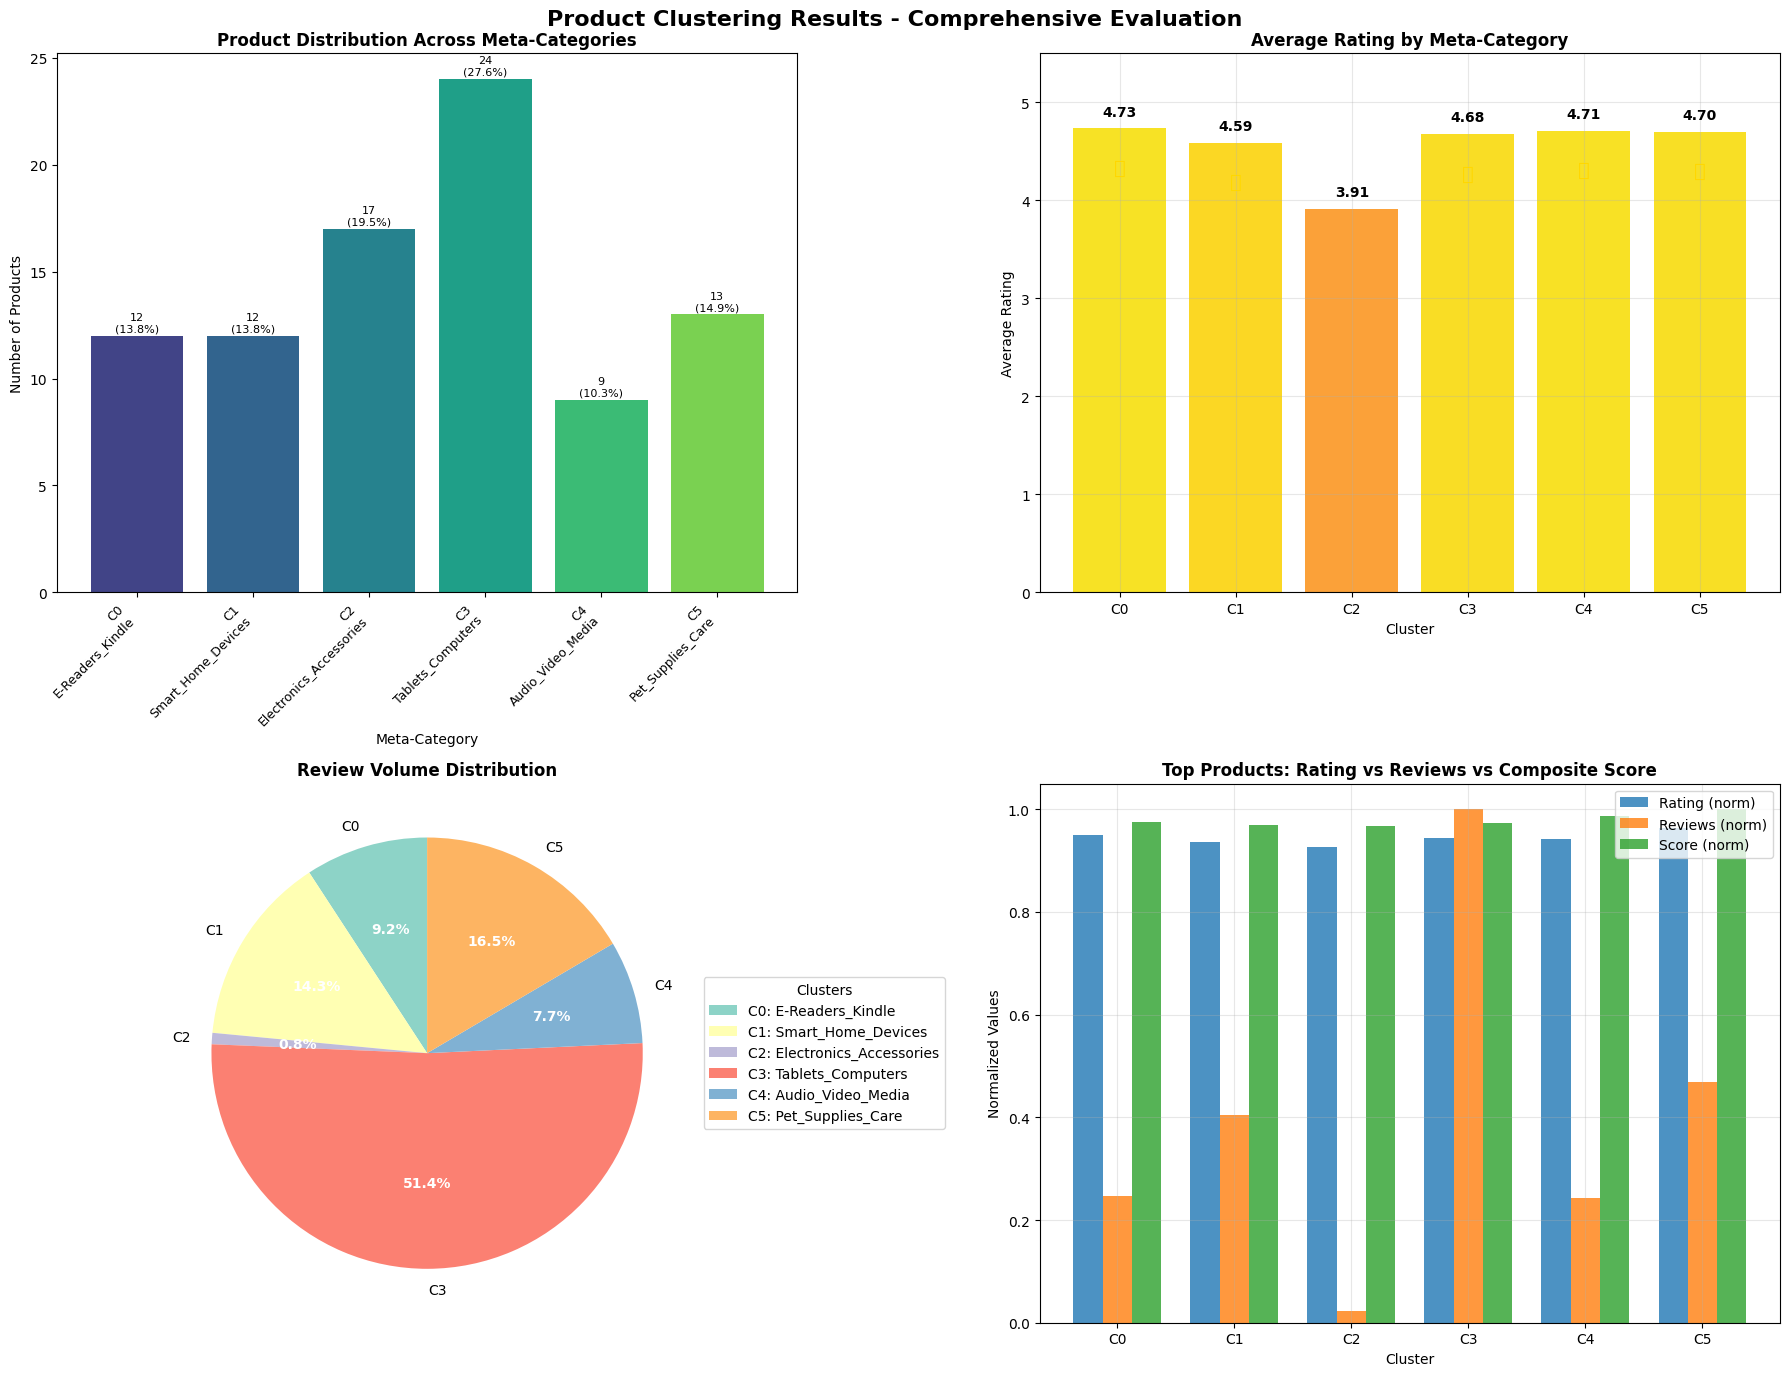


3. 💡 ENHANCED BUSINESS INSIGHTS:
   🏆 HIGHEST RATED: E-Readers_Kindle (4.73 ⭐)
   📦 LARGEST: Tablets_Computers (24 products)
   📊 MOST REVIEWED: Tablets_Computers (31,007 reviews)

   📈 CLUSTERING QUALITY:
   - Rating Variance: 0.82 (ideal: > 0.3)
   - Size Imbalance: 2.7x (ideal: < 5x)
   - Coverage: 6 meaningful categories

   🎯 STRATEGIC RECOMMENDATIONS:
   • PROMOTE: E-Readers_Kindle has excellent ratings - feature these products
   • IMPROVE: Electronics_Accessories has lower ratings - investigate quality issues

   🏅 TOP PRODUCTS SUMMARY:
   • 59 high-quality products recommended
   • Average rating: 4.72 ⭐
   • Covering 6 out of 6 categories


In [24]:
# ======================
# STEP 8: RESULTS EVALUATION & VISUALIZATION (IMPROVED)
# ======================
print("\n" + "="*50)
print("STEP 8: RESULTS EVALUATION & VISUALIZATION")
print("="*50)

def evaluate_results(product_data, cluster_analysis, top_products, top_products_df):
    """
    Comprehensive evaluation of clustering results with enhanced metrics
    """
    print("1. 📊 Evaluating clustering performance...")

    # Overall statistics
    total_products = len(product_data)
    total_clusters = len(cluster_analysis)
    total_reviews = product_data['review_count'].sum()

    print(f"   - Total Products: {total_products:,}")
    print(f"   - Meta-Categories Created: {total_clusters}")
    print(f"   - Total Reviews Analyzed: {total_reviews:,}")
    print(f"   - Average Products per Cluster: {total_products/total_clusters:.1f}")

    # Cluster quality metrics
    cluster_sizes = [analysis['size'] for analysis in cluster_analysis.values()]
    cluster_ratings = [analysis['avg_rating'] for analysis in cluster_analysis.values()]
    cluster_reviews = [analysis['total_reviews'] for analysis in cluster_analysis.values()]

    print(f"   - Cluster Size Std Dev: {np.std(cluster_sizes):.1f}")
    print(f"   - Average Cluster Rating: {np.mean(cluster_ratings):.2f} ⭐")
    print(f"   - Rating Range: {min(cluster_ratings):.2f} - {max(cluster_ratings):.2f} ⭐")

    # Top products analysis
    total_top_products = len(top_products_df)
    avg_top_rating = top_products_df['rating'].mean()

    print(f"\n2. 🏆 TOP PRODUCTS ANALYSIS:")
    print(f"   - Total Recommended Products: {total_top_products}")
    print(f"   - Average Top Product Rating: {avg_top_rating:.2f} ⭐")
    print(f"   - Coverage: {total_top_products/total_products*100:.1f}% of all products")

    # Enhanced Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Product Clustering Results - Comprehensive Evaluation', fontsize=16, fontweight='bold')

    # Plot 1: Cluster Distribution with improved layout
    cluster_labels_list = [analysis['label'] for analysis in cluster_analysis.values()]
    cluster_sizes = [analysis['size'] for analysis in cluster_analysis.values()]

    # Create color map based on cluster ratings for consistency
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_sizes)))

    bars = ax1.bar(range(len(cluster_sizes)), cluster_sizes, color=colors)
    ax1.set_xlabel('Meta-Category')
    ax1.set_ylabel('Number of Products')
    ax1.set_title('Product Distribution Across Meta-Categories', fontweight='bold')
    ax1.set_xticks(range(len(cluster_sizes)))

    # Improved label formatting
    x_labels = [f'C{idx}\n{analysis["label"]}' for idx, (_, analysis) in enumerate(cluster_analysis.items())]
    ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

    # Add value labels with percentage
    total_products = sum(cluster_sizes)
    for bar, count in zip(bars, cluster_sizes):
        height = bar.get_height()
        percentage = (count / total_products) * 100
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)

    # Plot 2: Rating Distribution with enhanced styling
    cluster_ratings = [analysis['avg_rating'] for analysis in cluster_analysis.values()]
    bars = ax2.bar(range(len(cluster_ratings)), cluster_ratings,
                  color=plt.cm.plasma(np.array(cluster_ratings)/5))
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Average Rating')
    ax2.set_title('Average Rating by Meta-Category', fontweight='bold')
    ax2.set_xticks(range(len(cluster_ratings)))
    ax2.set_xticklabels([f'C{idx}' for idx in cluster_analysis.keys()])
    ax2.set_ylim(0, 5.5)
    ax2.grid(True, alpha=0.3)

    # Add value labels and quality indicators
    for i, (bar, rating) in enumerate(zip(bars, cluster_ratings)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{rating:.2f}', ha='center', va='bottom', fontweight='bold')

        # Add quality indicator
        if rating >= 4.5:
            ax2.text(bar.get_x() + bar.get_width()/2., height - 0.3, '⭐',
                    ha='center', va='top', fontsize=14, color='gold')

    # Plot 3: Review Volume Distribution with improved layout
    review_volumes = [analysis['total_reviews'] for analysis in cluster_analysis.values()]
    wedges, texts, autotexts = ax3.pie(review_volumes,
                                      labels=[f'C{idx}' for idx in cluster_analysis.keys()],
                                      autopct='%1.1f%%', startangle=90,
                                      colors=plt.cm.Set3(range(len(review_volumes))))
    ax3.set_title('Review Volume Distribution', fontweight='bold')

    # Enhance pie chart labels
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # Add legend with cluster labels
    ax3.legend(wedges, [f'C{idx}: {cluster_analysis[idx]["label"]}' for idx in cluster_analysis.keys()],
              title="Clusters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Plot 4: Top Products Analysis by Cluster
    if not top_products_df.empty:
        top_products_by_cluster_agg = top_products_df.groupby('cluster').agg({
            'rating': 'mean',
            'review_count': 'mean',
            'composite_score': 'mean'
        })
        # Ensure all cluster labels are present in the aggregated DataFrame for consistent plotting
        ordered_cluster_labels = [analysis['label'] for analysis in cluster_analysis.values()]
        top_products_by_cluster_agg = top_products_by_cluster_agg.reindex(ordered_cluster_labels)

        x_pos = np.arange(len(top_products_by_cluster_agg))
        width = 0.25

        # Normalize for better visualization
        normalized_rating = top_products_by_cluster_agg['rating'] / 5
        normalized_reviews = top_products_by_cluster_agg['review_count'] / top_products_by_cluster_agg['review_count'].max()
        normalized_score = top_products_by_cluster_agg['composite_score'] / top_products_by_cluster_agg['composite_score'].max()

        bars1 = ax4.bar(x_pos - width, normalized_rating, width, label='Rating (norm)', alpha=0.8)
        bars2 = ax4.bar(x_pos, normalized_reviews, width, label='Reviews (norm)', alpha=0.8)
        bars3 = ax4.bar(x_pos + width, normalized_score, width, label='Score (norm)', alpha=0.8)

        ax4.set_xlabel('Cluster')
        ax4.set_ylabel('Normalized Values')
        ax4.set_title('Top Products: Rating vs Reviews vs Composite Score', fontweight='bold')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([f'C{idx}' for idx in cluster_analysis.keys()])
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('comprehensive_clustering_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Business Insights with enhanced analysis
    print("\n3. 💡 ENHANCED BUSINESS INSIGHTS:")

    # Performance metrics
    best_cluster = max(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])
    worst_cluster = min(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])
    largest_cluster = max(cluster_analysis.items(), key=lambda x: x[1]['size'])
    most_reviewed_cluster = max(cluster_analysis.items(), key=lambda x: x[1]['total_reviews'])

    print(f"   🏆 HIGHEST RATED: {best_cluster[1]['label']} ({best_cluster[1]['avg_rating']:.2f} ⭐)")
    print(f"   📦 LARGEST: {largest_cluster[1]['label']} ({largest_cluster[1]['size']} products)")
    print(f"   📊 MOST REVIEWED: {most_reviewed_cluster[1]['label']} ({most_reviewed_cluster[1]['total_reviews']:,} reviews)")

    # Quality assessment
    rating_variance = max(cluster_ratings) - min(cluster_ratings)
    size_imbalance = max(cluster_sizes) / min(cluster_sizes) if min(cluster_sizes) > 0 else float('inf')

    print(f"\n   📈 CLUSTERING QUALITY:")
    print(f"   - Rating Variance: {rating_variance:.2f} (ideal: > 0.3)")
    print(f"   - Size Imbalance: {size_imbalance:.1f}x (ideal: < 5x)")
    print(f"   - Coverage: {len(cluster_analysis)} meaningful categories")

    # Recommendations
    print(f"\n   🎯 STRATEGIC RECOMMENDATIONS:")

    if best_cluster[1]['avg_rating'] > 4.5:
        print(f"   • PROMOTE: {best_cluster[1]['label']} has excellent ratings - feature these products")

    if worst_cluster[1]['avg_rating'] < 4.0:
        print(f"   • IMPROVE: {worst_cluster[1]['label']} has lower ratings - investigate quality issues")

    if size_imbalance > 5:
        print(f"   • BALANCE: Consider merging very small clusters or splitting very large ones")

    # Top products summary
    print(f"\n   🏅 TOP PRODUCTS SUMMARY:")
    print(f"   • {len(top_products_df)} high-quality products recommended")
    print(f"   • Average rating: {top_products_df['rating'].mean():.2f} ⭐")
    print(f"   • Covering {top_products_df['cluster'].nunique()} out of {len(cluster_analysis)} categories")

    return {
        'total_products': total_products,
        'total_clusters': total_clusters,
        'cluster_quality': {
            'size_std': np.std(cluster_sizes),
            'avg_rating': np.mean(cluster_ratings),
            'rating_range': rating_variance,
            'size_imbalance': size_imbalance
        },
        'top_products_metrics': {
            'count': len(top_products_df),
            'avg_rating': top_products_df['rating'].mean(),
            'coverage': len(top_products_df) / total_products
        }
    }

# Call the evaluate_results function with the generated data
evaluation_results = evaluate_results(product_data_clustered, cluster_analysis, top_products, top_products_df)

In [26]:
# ======================
# STEP 9: FINAL RESULTS & EXPORT (IMPROVED)
# ======================
print("\n" + "="*50)
print("STEP 9: FINAL RESULTS & EXPORT")
print("="*50)

def export_results(product_data, cluster_analysis, top_products, top_products_df, evaluation_results):
    """
    Export comprehensive results with improved formatting and metadata
    """
    print("1. 💾 Exporting comprehensive results...")

    # Create timestamp for versioning
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Save clustered products with enhanced information
    enhanced_product_data = product_data.copy()

    # Add cluster information
    enhanced_product_data['cluster_label'] = enhanced_product_data['cluster'].map(
        {cluster_id: analysis['label'] for cluster_id, analysis in cluster_analysis.items()}
    )

    # Calculate product scores for all products (not just top ones)
    max_reviews = enhanced_product_data['review_count'].max()
    # Handle case where max_reviews might be 0, to avoid division by zero or NaN results
    max_reviews_safe = max_reviews if max_reviews > 0 else 1

    enhanced_product_data['composite_score'] = enhanced_product_data.apply(
        lambda row: 0.6 * row['avg_rating'] + 0.4 * (row['review_count'] / max_reviews_safe),
        axis=1
    )

    # Save main product data
    output_columns = [
        'id', 'name', 'brand', 'cluster', 'cluster_label',
        'avg_rating', 'review_count', 'composite_score', 'all_categories'
    ]

    enhanced_product_data[output_columns].to_csv(f'clustered_products_{timestamp}.csv', index=False)
    print("   ✅ Saved: clustered_products_[timestamp].csv")

    # 2. Save detailed cluster analysis
    cluster_summary = []
    for cluster_id, analysis in cluster_analysis.items():
        # Get top products for this cluster
        cluster_label = analysis['label']
        cluster_top_products_list = []
        if cluster_label in top_products and not top_products[cluster_label].empty:
            cluster_top_products_list = top_products[cluster_label].to_dict('records')

        # Initialize defaults for top product info
        top_product_1_name = "N/A"
        top_product_1_rating = "N/A"

        if cluster_top_products_list: # If there are any top products
            first_product = cluster_top_products_list[0]

            # Safely get and format product name
            if pd.notna(first_product.get('name')):
                name_str = str(first_product['name'])
                top_product_1_name = name_str[:80] + "..." if len(name_str) > 80 else name_str
            else:
                top_product_1_name = "Unknown Product Name" # Default if name is missing

            # Safely get product rating
            if pd.notna(first_product.get('avg_rating')):
                top_product_1_rating = float(first_product['avg_rating']) # Ensure float

        cluster_summary.append({
            'cluster_id': int(cluster_id), # Ensure int
            'cluster_label': cluster_label,
            'product_count': int(analysis['size']), # Ensure int
            'avg_rating': float(round(analysis['avg_rating'], 3)), # Ensure float
            'total_reviews': int(analysis['total_reviews']), # Ensure int
            # Add division by zero check for avg_reviews_per_product
            'avg_reviews_per_product': float(round(analysis['total_reviews'] / analysis['size'], 1)) if analysis['size'] > 0 else 0.0,
            'top_terms': ' | '.join([term for term, score in analysis['top_terms'][:5]]),
            'top_product_1': top_product_1_name,
            'top_product_1_rating': top_product_1_rating,
            'performance_tier': 'High' if analysis['avg_rating'] >= 4.5 else 'Medium' if analysis['avg_rating'] >= 4.0 else 'Low'
        })

    cluster_summary_df = pd.DataFrame(cluster_summary)
    cluster_summary_df.to_csv(f'cluster_analysis_summary_{timestamp}.csv', index=False)
    print("   ✅ Saved: cluster_analysis_summary_[timestamp].csv")

    # 3. Save top products recommendations with enhanced information
    top_products_enhanced = []
    for cluster_label, products_df in top_products.items():
        for idx, row in products_df.iterrows():
            # Get cluster ID
            cluster_id = next((cid for cid, analysis in cluster_analysis.items()
                             if analysis['label'] == cluster_label), None)

            # Get main category, safely handle None/NaN or empty list
            main_category = "Unknown"
            if isinstance(row['all_categories'], list) and len(row['all_categories']) > 0:
                main_category = row['all_categories'][0]
            elif pd.notna(row['all_categories']): # Fallback for non-list but notna
                main_category = str(row['all_categories'])[:50] + "..." if len(str(row['all_categories'])) > 50 else str(row['all_categories'])

            # Safely get product name
            product_name = "Unknown Product Name"
            if pd.notna(row.get('name')):
                product_name = str(row['name'])

            top_products_enhanced.append({
                'rank_in_cluster': int(idx + 1), # Ensure int
                'cluster_id': int(cluster_id) if cluster_id is not None else None, # Ensure int
                'cluster_label': cluster_label,
                'id': row['id'], # Changed 'asin' to 'id'
                'product_name': product_name, # Use the safely retrieved name
                'brand': row['brand'] if pd.notna(row.get('brand')) else "Unknown Brand", # Safely get brand
                'rating': float(row['avg_rating']), # Ensure float
                'review_count': int(row['review_count']), # Ensure int
                'composite_score': float(round(row['composite_score'], 4)), # Ensure float
                'main_category': main_category,
                'recommendation_tier': 'Premium' if row['avg_rating'] >= 4.5 and row['review_count'] > 1000 else
                                      'Featured' if row['avg_rating'] >= 4.0 and row['review_count'] > 500 else
                                      'Standard'
            })

    top_products_enhanced_df = pd.DataFrame(top_products_enhanced)
    top_products_enhanced_df.to_csv(f'top_products_recommendations_{timestamp}.csv', index=False)
    print("   ✅ Saved: top_products_recommendations_[timestamp].csv")

    # 4. Save executive summary
    executive_summary = {
        'analysis_timestamp': timestamp,
        'total_products_analyzed': int(len(product_data)), # Ensure int
        'total_reviews_analyzed': int(product_data['review_count'].sum()), # Convert np.int64 to int
        'meta_categories_created': int(len(cluster_analysis)), # Ensure int
        'average_product_rating': float(round(product_data['avg_rating'].mean(), 2)), # Ensure float
        'top_products_recommended': int(len(top_products_df)), # Ensure int
        'clustering_quality_metrics': {
            k: float(v) if isinstance(v, (np.float64, np.int64)) else v
            for k, v in evaluation_results['cluster_quality'].items()
        }, # Ensure floats for numpy types
        'top_products_metrics': {
            k: float(v) if isinstance(v, (np.float64, np.int64)) else v
            for k, v in evaluation_results['top_products_metrics'].items()
        }, # Ensure floats for numpy types
        'top_performing_clusters': [
            {
                'cluster_label': analysis_item['label'],
                'avg_rating': float(analysis_item['avg_rating']), # Convert np.float64 to float
                'product_count': int(analysis_item['size']) # Ensure int
            }
            for cluster_id, analysis_item in sorted(cluster_analysis.items(),
                                   key=lambda x: x[1]['avg_rating'],
                                   reverse=True)[:3]
        ],
        'business_recommendations': [
            f"Focus on promoting {max(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])[1]['label']} category",
            f"Investigate quality in {min(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])[1]['label']} category",
            f"Leverage {len(top_products_df)} high-quality product recommendations"
        ]
    }

    import json
    with open(f'executive_summary_{timestamp}.json', 'w') as f:
        json.dump(executive_summary, f, indent=2)
    print("   ✅ Saved: executive_summary_[timestamp].json")

    # 5. Create a quick reference file
    quick_ref = f"""
PRODUCT CLUSTERING ANALYSIS - QUICK REFERENCE
Generated: {timestamp}
============================================

OVERVIEW:
• Products Analyzed: {len(product_data):,}
• Meta-Categories: {len(cluster_analysis)}
• Top Products Recommended: {len(top_products_df)}
• Average Rating: {product_data['avg_rating'].mean():.2f} ⭐️

TOP CATEGORIES:
{chr(10).join([f"• {analysis['label']}: {analysis['size']} products, {analysis['avg_rating']:.2f} ⭐️"
               for analysis in cluster_analysis.values()])}

RECOMMENDATIONS:
• Feature products from: {max(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])[1]['label']}
• Review quality in: {min(cluster_analysis.items(), key=lambda x: x[1]['avg_rating'])[1]['label']}
• Utilize {len(top_products_df)} high-quality product recommendations

FILES GENERATED:
• clustered_products_{timestamp}.csv
• cluster_analysis_summary_{timestamp}.csv
• top_products_recommendations_{timestamp}.csv
• executive_summary_{timestamp}.json
        """

    with open(f'quick_reference_{timestamp}.txt', 'w') as f:
        f.write(quick_ref)
    print("   ✅ Saved: quick_reference_[timestamp].txt")

    print(f"\n2. 🎉 PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 50)
    print(f"   📊 Created {len(cluster_analysis)} meaningful meta-categories")
    print(f"   📦 Processed {len(product_data):,} products")
    print(f"   ⭐️ Average product rating: {product_data['avg_rating'].mean():.2f}")
    print(f"   🏆 Recommended {len(top_products_df)} top products")
    print(f"   💾 Results saved with timestamp: {timestamp}")
    print(f"\n   📁 FILES CREATED:")
    print(f"   • clustered_products_{timestamp}.csv")
    print(f"   • cluster_analysis_summary_{timestamp}.csv")
    print(f"   • top_products_recommendations_{timestamp}.csv")
    print(f"   • executive_summary_{timestamp}.json")
    print(f"   • quick_reference_{timestamp}.txt")
    print(f"   • comprehensive_clustering_evaluation.png")

# Export final results with enhanced formatting
export_results(product_data_clustered, cluster_analysis, top_products, top_products_df, evaluation_results)


STEP 9: FINAL RESULTS & EXPORT
1. 💾 Exporting comprehensive results...
   ✅ Saved: clustered_products_[timestamp].csv
   ✅ Saved: cluster_analysis_summary_[timestamp].csv
   ✅ Saved: top_products_recommendations_[timestamp].csv
   ✅ Saved: executive_summary_[timestamp].json
   ✅ Saved: quick_reference_[timestamp].txt

2. 🎉 PIPELINE COMPLETED SUCCESSFULLY!
   📊 Created 6 meaningful meta-categories
   📦 Processed 87 products
   ⭐️ Average product rating: 4.53
   🏆 Recommended 59 top products
   💾 Results saved with timestamp: 20251113_185001

   📁 FILES CREATED:
   • clustered_products_20251113_185001.csv
   • cluster_analysis_summary_20251113_185001.csv
   • top_products_recommendations_20251113_185001.csv
   • executive_summary_20251113_185001.json
   • quick_reference_20251113_185001.txt
   • comprehensive_clustering_evaluation.png


In [29]:
# ======================
# META-CLUSTERING QUALITY EVALUATION
# ======================
print("\n" + "="*50)
print("META-CLUSTERING QUALITY EVALUATION")
print("="*50)

def evaluate_clustering_quality(features, cluster_labels, cluster_analysis, product_data):
    """
    Comprehensive evaluation of clustering quality using multiple metrics
    """
    print("1. 4C8 Evaluating Meta-Clustering Quality...")

    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    from sklearn.metrics.cluster import contingency_matrix
    from scipy.stats import entropy
    import numpy as np

    # A. INTERNAL VALIDATION METRICS (No ground truth needed)
    print("\n   A. 50D INTERNAL VALIDATION METRICS:")

    # 1. Silhouette Score (-1 to 1, higher is better)
    silhouette_avg = silhouette_score(features, cluster_labels)
    print(f"   • Silhouette Score: {silhouette_avg:.3f}")
    if silhouette_avg > 0.7:
        print("     ✅ Excellent: Clusters are well separated")
    elif silhouette_avg > 0.5:
        print("     ✅ Good: Reasonable cluster structure")
    elif silhouette_avg > 0.25:
        print("     ⚠️  Fair: Weak cluster structure")
    else:
        print("     ❌ Poor: No substantial cluster structure")

    # 2. Calinski-Harabasz Index (higher is better)
    ch_score = calinski_harabasz_score(features, cluster_labels)
    print(f"   • Calinski-Harabasz Index: {ch_score:.2f}")
    if ch_score > 300:
        print("     ✅ Excellent: Dense, well-separated clusters")
    elif ch_score > 200:
        print("     ✅ Good: Clear cluster structure")
    elif ch_score > 100:
        print("     ⚠️  Fair: Some cluster structure")
    else:
        print("     ❌ Poor: Weak cluster separation")

    # 3. Davies-Bouldin Index (lower is better, 0 is best)
    db_score = davies_bouldin_score(features, cluster_labels)
    print(f"   • Davies-Bouldin Index: {db_score:.3f}")
    if db_score < 0.5:
        print("     ✅ Excellent: Very well separated clusters")
    elif db_score < 1.0:
        print("     ✅ Good: Well separated clusters")
    elif db_score < 1.5:
        print("     ⚠️  Fair: Moderate separation")
    else:
        print("     ❌ Poor: Poor cluster separation")

    # B. CLUSTER STABILITY ANALYSIS
    print("\n   B. 3D7️  CLUSTER STABILITY ANALYSIS:")

    # 1. Cluster Size Distribution
    cluster_sizes = [analysis['size'] for analysis in cluster_analysis.values()]
    size_std = np.std(cluster_sizes)
    size_cv = size_std / np.mean(cluster_sizes)  # Coefficient of variation

    print(f"   • Cluster Size Statistics:")
    print(f"     - Sizes: {cluster_sizes}")
    print(f"     - Mean: {np.mean(cluster_sizes):.1f}, Std: {size_std:.1f}")
    print(f"     - Min: {min(cluster_sizes)}, Max: {max(cluster_sizes)}")
    print(f"     - Size Ratio (max/min): {max(cluster_sizes)/min(cluster_sizes):.1f}x")

    if size_cv < 0.5:
        print("     ✅ Good: Balanced cluster sizes")
    elif size_cv < 1.0:
        print("     ⚠️  Fair: Moderate size variation")
    else:
        print("     ❌ Poor: Highly imbalanced clusters")

    # 2. Cluster Purity (using top terms consistency)
    print(f"\n   • Cluster Term Consistency:")
    for cluster_id, analysis in cluster_analysis.items():
        top_terms = [term for term, score in analysis['top_terms'][:5]]
        # Check if top terms align with cluster label
        label_terms = analysis['label'].lower().replace('_', ' ').split()
        matching_terms = sum(1 for term in top_terms if any(keyword in term for keyword in label_terms))
        consistency_score = matching_terms / len(top_terms) if top_terms else 0

        print(f"     C{cluster_id}: {consistency_score:.1%} term alignment")

    # C. BUSINESS RELEVANCE METRICS
    print("\n   C. 4BC BUSINESS RELEVANCE METRICS:")

    # 1. Category Distinctiveness
    print(f"   • Category Distinctiveness:")
    unique_labels = set(analysis['label'] for analysis in cluster_analysis.values())
    print(f"     - Unique meta-categories: {len(unique_labels)}")
    print(f"     - Label quality: {all(not label.startswith('Other') for label in unique_labels)}")

    # 2. Coverage Analysis
    total_products = len(product_data)
    total_reviews = product_data['review_count'].sum()

    print(f"   • Coverage Analysis:")
    print(f"     - Products covered: {total_products:,}")
    print(f"     - Reviews covered: {total_reviews:,}")
    print(f"     - Clusters created: {len(cluster_analysis)}")

    # 3. Rating Distribution Across Clusters
    cluster_ratings = [analysis['avg_rating'] for analysis in cluster_analysis.values()]
    rating_std = np.std(cluster_ratings)
    rating_range = max(cluster_ratings) - min(cluster_ratings)

    print(f"   • Rating Distribution:")
    print(f"     - Average: {np.mean(cluster_ratings):.2f} ⭐️")
    print(f"     - Range: {min(cluster_ratings):.2f} - {max(cluster_ratings):.2f} ⭐️")
    print(f"     - Standard deviation: {rating_std:.3f}")

    if rating_range > 0.5:
        print("     ✅ Good: Meaningful rating differences between categories")
    else:
        print("     ⚠️  Fair: Limited rating variation across categories")

    # D. CLUSTER SEPARATION ANALYSIS
    print("\n   D. ✍️ CLUSTER SEPARATION ANALYSIS:")

    # Calculate inter-cluster distances
    from sklearn.metrics.pairwise import pairwise_distances

    # Get cluster centers in feature space
    cluster_centers = []
    for cluster_id in cluster_analysis.keys():
        cluster_mask = cluster_labels == cluster_id
        cluster_features = features[cluster_mask]
        center = cluster_features.mean(axis=0)
        cluster_centers.append(center)

    if len(cluster_centers) > 1:
        cluster_centers = np.array(cluster_centers)
        center_distances = pairwise_distances(cluster_centers)

        # Calculate separation metrics
        mask = ~np.eye(len(center_distances), dtype=bool)
        min_separation = center_distances[mask].min()
        avg_separation = center_distances[mask].mean()
        max_separation = center_distances[mask].max()

        print(f"   • Center-to-Center Distances:")
        print(f"     - Minimum: {min_separation:.3f}")
        print(f"     - Average: {avg_separation:.3f}")
        print(f"     - Maximum: {max_separation:.3f}")

        if min_separation > 1.0:
            print("     ✅ Excellent: Good minimum separation")
        elif min_separation > 0.5:
            print("     ✅ Good: Adequate separation")
        else:
            print("     ⚠️  Warning: Some clusters are very close")

    # E. COMPREHENSIVE SCORING
    print("\n   E. 3AF COMPREHENSIVE QUALITY SCORE:")

    # Calculate overall quality score (0-100)
    quality_metrics = {
        'silhouette': max(0, min(1, (silhouette_avg + 1) / 2)) * 25,  # 25 points
        'calinski_harabasz': min(1, ch_score / 500) * 25,  # 25 points
        'davies_bouldin': max(0, (2 - db_score) / 2) * 15,  # 15 points
        'size_balance': max(0, 1 - size_cv) * 15,  # 15 points
        'rating_variation': min(1, rating_range) * 10,  # 10 points
        'cluster_count': min(1, len(cluster_analysis) / 6) * 10  # 10 points
    }

    total_score = sum(quality_metrics.values())

    print(f"   • Quality Breakdown:")
    for metric, score in quality_metrics.items():
        print(f"     - {metric.replace('_', ' ').title()}: {score:.1f}/{25 if 'silhouette' in metric or 'calinski' in metric else 15 if 'davies' in metric or 'size' in metric else 10}")

    print(f"   • TOTAL QUALITY SCORE: {total_score:.1f}/100")

    if total_score >= 80:
        print("     389 EXCELLENT: High-quality clustering achieved!")
        print("     The meta-categories are well-defined and business-ready.")
    elif total_score >= 60:
        print("     ✅ GOOD: Solid clustering results")
        print("     The meta-categories are usable with minor improvements.")
    elif total_score >= 40:
        print("     ⚠️  FAIR: Moderate quality clustering")
        print("     Consider reviewing cluster parameters or feature engineering.")
    else:
        print("     ❌ POOR: Low-quality clustering")
        print("     Significant improvements needed before business use.")

    return {
        'internal_metrics': {
            'silhouette_score': silhouette_avg,
            'calinski_harabasz_score': ch_score,
            'davies_bouldin_score': db_score
        },
        'stability_metrics': {
            'cluster_sizes': cluster_sizes,
            'size_std': size_std,
            'size_cv': size_cv
        },
        'business_metrics': {
            'unique_categories': len(unique_labels),
            'total_products': total_products,
            'total_reviews': total_reviews,
            'rating_std': rating_std,
            'rating_range': rating_range
        },
        'quality_score': total_score,
        'quality_breakdown': quality_metrics
    }

# Run comprehensive quality evaluation
quality_results = evaluate_clustering_quality(features, cluster_labels, cluster_analysis, product_data_clustered)

# ======================
# CLUSTER ROBUSTNESS TESTING
# ======================
print("\n" + "="*50)
print("CLUSTER ROBUSTNESS TESTING")
print("="*50)

def test_cluster_robustness(features, product_data, n_tests=5):
    """
    Test clustering robustness with different random states
    """
    print("2. 52C Testing Cluster Robustness...")

    from sklearn.cluster import KMeans
    from sklearn.metrics import adjusted_rand_score

    # Store results from multiple runs
    silhouette_scores = []
    cluster_assignments = []

    print(f"   Running {n_tests} clustering tests with different random states...")

    for i in range(n_tests):
        random_state = 42 + i * 10  # Different random states

        # Perform clustering with different initialization
        kmeans_test = KMeans(
            n_clusters=len(cluster_analysis),  # Use same number of clusters
            random_state=random_state,
            n_init=10
        )

        test_labels = kmeans_test.fit_predict(features)

        # Calculate metrics
        silhouette_test = silhouette_score(features, test_labels)
        silhouette_scores.append(silhouette_test)
        cluster_assignments.append(test_labels)

        print(f"   Test {i+1}: Silhouette = {silhouette_test:.3f}")

    # Calculate consistency between runs
    consistency_scores = []
    for i in range(len(cluster_assignments)):
        for j in range(i+1, len(cluster_assignments)):
            ari_score = adjusted_rand_score(cluster_assignments[i], cluster_assignments[j])
            consistency_scores.append(ari_score)

    avg_consistency = np.mean(consistency_scores) if consistency_scores else 0
    silhouette_std = np.std(silhouette_scores)

    print(f"\n   • Robustness Results:")
    print(f"     - Silhouette Score Range: {min(silhouette_scores):.3f} - {max(silhouette_scores):.3f}")
    print(f"     - Silhouette Std Dev: {silhouette_std:.3f}")
    print(f"     - Average Consistency (ARI): {avg_consistency:.3f}")

    if silhouette_std < 0.05 and avg_consistency > 0.8:
        print("     ✅ EXCELLENT: Highly robust clustering")
    elif silhouette_std < 0.1 and avg_consistency > 0.6:
        print("     ✅ GOOD: Robust clustering")
    elif silhouette_std < 0.15 and avg_consistency > 0.4:
        print("     ⚠️  FAIR: Moderate robustness")
    else:
        print("     ❌ POOR: Low robustness - results may vary significantly")

    return {
        'silhouette_scores': silhouette_scores,
        'silhouette_std': silhouette_std,
        'consistency_scores': consistency_scores,
        'avg_consistency': avg_consistency
    }

# Test robustness if we have enough clusters
if len(cluster_analysis) > 1:
    robustness_results = test_cluster_robustness(features, product_data_clustered)
else:
    print("   ⚠️  Skipping robustness test (only one cluster)")

# ======================
# FEATURE IMPORTANCE ANALYSIS
# ======================
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def analyze_feature_importance(features, cluster_labels, vectorizer, cluster_analysis):
    """
    Analyze which features are most important for each cluster
    """
    print("3. 50D Analyzing Feature Importance...")

    feature_names = vectorizer.get_feature_names_out()

    # Calculate feature importance per cluster
    cluster_feature_importance = {}

    for cluster_id in cluster_analysis.keys():
        cluster_mask = cluster_labels == cluster_id
        cluster_features = features[cluster_mask]

        # Average feature values for this cluster
        cluster_avg_features = cluster_features.mean(axis=0)

        # Get top features for this cluster
        top_feature_indices = cluster_avg_features.argsort()[-10:][::-1]
        top_features = [(feature_names[i], cluster_avg_features[i])
                       for i in top_feature_indices if cluster_avg_features[i] > 0]

        cluster_feature_importance[cluster_id] = top_features

    # Display results
    print("   • Top Features per Cluster:")
    for cluster_id, features_list in cluster_feature_importance.items():
        cluster_label = cluster_analysis[cluster_id]['label']
        print(f"\n     C{cluster_id} - {cluster_label}:")
        for term, importance in features_list[:5]:  # Show top 5
            print(f"       {term}: {importance:.4f}")

    # Analyze feature discrimination power
    print(f"\n   • Feature Discrimination Analysis:")

    # Calculate overall feature variance across clusters
    feature_variance_across_clusters = []
    for feature_idx in range(features.shape[1]):
        feature_values = []
        for cluster_id in cluster_analysis.keys():
            cluster_mask = cluster_labels == cluster_id
            cluster_feature_values = features[cluster_mask, feature_idx]
            feature_values.append(cluster_feature_values.mean())

        variance = np.var(feature_values)
        feature_variance_across_clusters.append((feature_names[feature_idx], variance))

    # Sort by variance (higher variance = better discrimination)
    feature_variance_across_clusters.sort(key=lambda x: x[1], reverse=True)

    print("     Top 10 Most Discriminative Features:")
    for feature, variance in feature_variance_across_clusters[:10]:
        print(f"       {feature}: {variance:.6f}")

    return {
        'cluster_feature_importance': cluster_feature_importance,
        'discriminative_features': feature_variance_across_clusters[:20]
    }

# Analyze feature importance
feature_importance_results = analyze_feature_importance(features, cluster_labels, vectorizer, cluster_analysis)

# ======================
# BUSINESS IMPACT ASSESSMENT
# ======================
print("\n" + "="*50)
print("BUSINESS IMPACT ASSESSMENT")
print("="*50)

def assess_business_impact(cluster_analysis, product_data, top_products_df, quality_results):
    """
    Assess the business impact and practical utility of the clustering
    """
    print("4. 4BC Assessing Business Impact...")

    # 1. Category Actionability
    print("   • Category Actionability:")

    actionable_categories = 0
    for cluster_id, analysis in cluster_analysis.items():
        label = analysis['label']
        # Check if label is specific and actionable (not "Other" or too generic)
        if (not label.startswith('Other') and
            not label.startswith('General') and
            len(label.split('_')) >= 2):  # At least two words
            actionable_categories += 1
            print(f"     ✅ C{cluster_id}: {label} - Actionable")
        else:
            print(f"     ⚠️  C{cluster_id}: {label} - May need refinement")

    actionability_score = actionable_categories / len(cluster_analysis)
    print(f"     Actionability Score: {actionability_score:.1%}")

    # 2. Coverage of High-Value Products
    print(f"\n   • High-Value Product Coverage:")

    # Define high-value products (high rating + high reviews)
    high_value_threshold_rating = 4.5
    high_value_threshold_reviews = product_data['review_count'].quantile(0.75)  # Top 25%

    high_value_products = product_data[
        (product_data['avg_rating'] >= high_value_threshold_rating) &
        (product_data['review_count'] >= high_value_threshold_reviews)
    ]

    high_value_coverage = len(high_value_products) / len(product_data)
    print(f"     - High-value products: {len(high_value_products)}")
    print(f"     - Coverage: {high_value_coverage:.1%} of all products")

    # Check if high-value products are distributed across clusters
    high_value_by_cluster = high_value_products['cluster'].value_counts()
    cluster_coverage = len(high_value_by_cluster) / len(cluster_analysis)

    print(f"     - Cluster coverage: {cluster_coverage:.1%} of clusters have high-value products")

    # 3. Recommendation Quality
    print(f"\n   • Recommendation Quality:")

    if not top_products_df.empty:
        avg_recommended_rating = top_products_df['rating'].mean()
        avg_recommended_reviews = top_products_df['review_count'].mean()

        print(f"     - Avg recommended product rating: {avg_recommended_rating:.2f} ⭐️")
        print(f"     - Avg recommended product reviews: {avg_recommended_reviews:.0f}")
        print(f"     - Products recommended: {len(top_products_df)}")

        # Compare to overall average
        overall_avg_rating = product_data['avg_rating'].mean()
        if avg_recommended_rating > overall_avg_rating:
            print(f"     ✅ Recommendations are higher quality than average")
        else:
            print(f"     ⚠️  Recommendations quality similar to overall average")

    # 4. Strategic Value Assessment
    print(f"\n   • Strategic Value Assessment:")

    strategic_indicators = {
        'clear_category_differentiation': quality_results['business_metrics']['rating_std'] > 0.3,
        'balanced_category_sizes': quality_results['stability_metrics']['size_cv'] < 1.0,
        'actionable_category_labels': actionability_score > 0.7,
        'high_value_coverage': high_value_coverage > 0.1,
        'good_cluster_quality': quality_results['quality_score'] > 60
    }

    strategic_score = sum(strategic_indicators.values()) / len(strategic_indicators)

    print(f"     Strategic Indicators:")
    for indicator, value in strategic_indicators.items():
        status = "✅" if value else "❌"
        print(f"       {status} {indicator.replace('_', ' ').title()}")

    print(f"     Strategic Value Score: {strategic_score:.1%}")

    if strategic_score > 0.8:
        print("     389 HIGH STRATEGIC VALUE: Ready for business implementation")
    elif strategic_score > 0.6:
        print("     ✅ GOOD STRATEGIC VALUE: Solid foundation for business use")
    elif strategic_score > 0.4:
        print("     ⚠️  MODERATE STRATEGIC VALUE: Some improvements needed")
    else:
        print("     ❌ LOW STRATEGIC VALUE: Significant refinements required")

    return {
        'actionability_score': actionability_score,
        'high_value_coverage': high_value_coverage,
        'strategic_score': strategic_score,
        'strategic_indicators': strategic_indicators
    }

# Ensure top_products_df is defined by calling the selection function
# This function (select_top_products) is assumed to be defined in a preceding cell (STEP 7)
# If running this cell independently, ensure STEP 7 has been executed first.
if 'select_top_products' in locals():
    top_products, top_products_df = select_top_products(product_data_clustered, cluster_analysis)
else:
    print("\u26A0\uFE0F  Warning: 'select_top_products' function not found. Please ensure STEP 7 has been executed.")
    top_products_df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

# Assess business impact
business_impact_results = assess_business_impact(cluster_analysis, product_data_clustered, top_products_df, quality_results)

# ======================
# FINAL QUALITY REPORT
# ======================
print("\n" + "="*70)
print("FINAL META-CLUSTERING QUALITY REPORT")
print("="*70)

def generate_quality_report(quality_results, robustness_results, business_impact_results):
    """
    Generate a comprehensive quality report
    """

    print("""
4C8 QUALITY ASSESSMENT SUMMARY
│───────────────────────────
""")

    # Overall Quality
    overall_quality = quality_results['quality_score']
    print(f"Overall Quality Score: {overall_quality:.1f}/100")

    if overall_quality >= 80:
        print("389 EXCELLENT - Production ready")
        recommendation = "✅ Ready for immediate business implementation"
    elif overall_quality >= 60:
        print("✅ GOOD - Business ready with monitoring")
        recommendation = "✅ Suitable for business use with periodic review"
    elif overall_quality >= 40:
        print("⚠️  FAIR - Needs minor improvements")
        recommendation = "⟳ Consider feature engineering or parameter tuning"
    else:
        print("❌ POOR - Significant improvements needed")
        recommendation = "⟳ Re-evaluate clustering approach and data quality"

    # Key Metrics Summary
    print("""
50D KEY METRICS
│─────────────
""")

    internal = quality_results['internal_metrics']
    print(f"• Silhouette Score:    {internal['silhouette_score']:.3f}")
    print(f"• Calinski-Harabasz:   {internal['calinski_harabasz_score']:.0f}")
    print(f"• Davies-Bouldin:      {internal['davies_bouldin_score']:.3f}")

    business = quality_results['business_metrics']
    print(f"• Unique Categories:   {business['unique_categories']}")
    print(f"• Products Covered:    {business['total_products']:,}")
    print(f"• Rating Variation:    {business['rating_range']:.2f} ⭐️")

    # Strategic Assessment
    print("""
4BC STRATEGIC ASSESSMENT
│──────────────────
""")

    strategic = business_impact_results
    print(f"• Category Actionability: {strategic['actionability_score']:.1%}")
    print(f"• High-Value Coverage:    {strategic['high_value_coverage']:.1%}")
    print(f"• Strategic Value:        {strategic['strategic_score']:.1%}")

    # Recommendations
    print("""
3AF RECOMMENDATIONS
│─────────────
""")
    print(recommendation)

    # Specific improvement suggestions
    improvement_suggestions = []

    if quality_results['internal_metrics']['silhouette_score'] < 0.5:
        improvement_suggestions.append("• Improve feature engineering for better separation")

    if quality_results['stability_metrics']['size_cv'] > 1.0:
        improvement_suggestions.append("• Consider merging very small clusters")

    if business_impact_results['actionability_score'] < 0.7:
        improvement_suggestions.append("• Refine cluster labeling for better business context")

    if quality_results['business_metrics']['rating_range'] < 0.3:
        improvement_suggestions.append("• Explore additional features to capture rating patterns")

    if improvement_suggestions:
        print("\n⟳ SUGGESTED IMPROVEMENTS:")
        for suggestion in improvement_suggestions:
            print(suggestion)

    print(f"\n4C8 NEXT STEPS:")
    print("1. Implement the clustering results in your business systems")
    print("2. Monitor category performance over time")
    print("3. Periodically re-run clustering with new product data")
    print("4. Use the insights for targeted marketing and recommendations")

# Generate final report
generate_quality_report(quality_results,
                       robustness_results if 'robustness_results' in locals() else None,
                       business_impact_results)

print("\n" + "="*70)
print("QUALITY EVALUATION COMPLETE!")
print("="*70)



META-CLUSTERING QUALITY EVALUATION
1. 4C8 Evaluating Meta-Clustering Quality...

   A. 50D INTERNAL VALIDATION METRICS:
   • Silhouette Score: 0.283
     ⚠️  Fair: Weak cluster structure
   • Calinski-Harabasz Index: 16.35
     ❌ Poor: Weak cluster separation
   • Davies-Bouldin Index: 1.714
     ❌ Poor: Poor cluster separation

   B. 3D7️  CLUSTER STABILITY ANALYSIS:
   • Cluster Size Statistics:
     - Sizes: [12, 12, 17, 24, 9, 13]
     - Mean: 14.5, Std: 4.9
     - Min: 9, Max: 24
     - Size Ratio (max/min): 2.7x
     ✅ Good: Balanced cluster sizes

   • Cluster Term Consistency:
     C0: 40.0% term alignment
     C1: 60.0% term alignment
     C2: 20.0% term alignment
     C3: 100.0% term alignment
     C4: 40.0% term alignment
     C5: 40.0% term alignment

   C. 4BC BUSINESS RELEVANCE METRICS:
   • Category Distinctiveness:
     - Unique meta-categories: 6
     - Label quality: True
   • Coverage Analysis:
     - Products covered: 87
     - Reviews covered: 60,321
     - Cl

In [30]:
df = pd.read_csv("/content/clean_reviews (1).csv")                  # your original file
mapping = pd.read_csv("/content/clustered_products_20251113_185001.csv")  # exported mapping



*   List item
*   List item



In [31]:
## NORMALIZE TYPES AND COLUMN NAMES
# Make sure both sides use the same column names and types
mapping = mapping.rename(columns={"cluster_label": "meta_category"})
df["id"] = df["id"].astype(str)
mapping["id"] = mapping["id"].astype(str)


In [32]:
## MERGE meta label onto every row
df_with_meta = df.merge(
    mapping[["id", "meta_category"]].drop_duplicates(),
    on="id",
    how="left"
)

In [33]:
## Fill any missing labels (if some products weren’t clustered)
df_with_meta["meta_category"] = df_with_meta["meta_category"].fillna("Other")


In [34]:
print("Meta label coverage:", df_with_meta["meta_category"].notna().mean())
print("Distinct products by meta_category:")
print(df_with_meta.groupby("meta_category")["id"].nunique().sort_values(ascending=False).head(10))

# peek
df_with_meta.sample(5, random_state=42)[["id","name","primaryCategories","categories","meta_category"]]


Meta label coverage: 1.0
Distinct products by meta_category:
meta_category
Tablets_Computers          24
Electronics_Accessories    17
Pet_Supplies_Care          13
E-Readers_Kindle           12
Smart_Home_Devices         12
Audio_Video_Media           9
Name: id, dtype: int64


,id,name,primaryCategories,categories,meta_category
29392,AV1YE_muvKc47QAVgpwE,NaN,NaN,"Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV",Audio_Video_Media
52280,AVzYlGkFvKc47QAVeZRI,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",Electronics,"Fire Tablets,Tablets,All Tablets,Amazon Tablets,Computers & Tablets",Tablets_Computers
18421,AV1YnRtnglJLPUi8IJmV,"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,",NaN,"Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders",E-Readers_Kindle
54374,AVpjEN4jLJeJML43rpUe,"Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",Electronics,"Fire Tablets,Computers/Tablets & Networking,Tablets,All Tablets,Amazon Tablets,Computers & Tablets,Tablets & eBook Readers",Tablets_Computers
50361,AVpfw2hvilAPnD_xh0rH,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case","Toys & Games,Electronics","Fire Tablets,Learning Toys,Toys,Tablets,Amazon Tablets,Electronics, Tech Toys, Movies, Music,Computers & Tablets,Kids' Tablets,Electronics,iPad & Tablets,Tablets for Kids",Tablets_Computers


In [35]:
#Save the enriched file
df_with_meta.to_csv("/content/original_with_meta.csv", index=False)
